# ***SWaT Dataset - Anomaly Detection***

* Clovis Lechien
* Alexandre Devaux-Rivière
* Florian Segard-Gahery
* Valentin San
* Maël Reynaud

In [155]:
from typing import Tuple, Any

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from os import listdir
import re

import mlsecu.data_exploration_utils as deu

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, balanced_accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

%matplotlib inline

In [92]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [93]:
!ls 'data/swat/'

22June2020_1.xlsx  22June2020_2.xlsx  29June2020_1.xlsx  29June2020_2.xlsx


In [94]:
def get_summary(df : pd.DataFrame) -> pd.DataFrame:
    df_desc = pd.DataFrame(df.describe(include='all').T)
    df_summary = pd.DataFrame({
        'dtype': df.dtypes,
        'unique':df.nunique().values,
        'missing': df.isna().sum().values,
        'duplicates': df.duplicated().sum(),
        'min': df_desc['min'].values,
        'max': df_desc['max'].values,
        'avg': df_desc['mean'].values,
        'std dev': df_desc['std'].values
    })
    return df_summary

In [95]:
def list_dir(path : str, pattern : str) -> list[str]:
    return [file for file in listdir(path) if re.search(pattern, file)]

In [96]:
def preproc_df(df : pd.DataFrame) -> pd.DataFrame:
    return df[df.columns.drop(list(df.filter(regex='Unnamed')))]

In [97]:
def concat_dfs(dfs_path : list[str]) -> pd.DataFrame:
    list_of_dfs = []
    for df_path in dfs_path:
        df = preproc_df(pd.read_excel(df_path))
        list_of_dfs.append(df)
    return pd.concat(list_of_dfs, axis=0)

In [98]:
path = 'data/swat_newdataset/SWaT.A3_dataset_Jul 19_labelled.xlsx'

df = pd.read_excel(path, skiprows=[0, 2])
df

,GMT +0,Attack,Label,FIT 101,LIT 101,MV 101,P1_STATE,P101 Status,P102 Status,AIT 201,...,LSH 601,LSH 602,LSH 603,LSL 601,LSL 602,LSL 603,P6 STATE,P601 Status,P602 Status,P603 Status
0,2019-07-20T04:30:00Z,benign,0,0.000000,729.865800,1,3,2,1,142.527557,...,"{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Active', u'Val...",2,1,1,1
1,2019-07-20T04:30:01Z,benign,0,0.000000,729.434000,1,3,2,1,142.527557,...,"{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Active', u'Val...",2,1,1,1
2,2019-07-20T04:30:02.004013Z,benign,0,0.000000,729.120000,1,3,2,1,142.527557,...,"{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Active', u'Val...",2,1,1,1
3,2019-07-20T04:30:03.004013Z,benign,0,0.000000,728.688200,1,3,2,1,142.527557,...,"{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Active', u'Val...",2,1,1,1
4,2019-07-20T04:30:04Z,benign,0,0.000000,727.706900,1,3,2,1,142.527557,...,"{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Active', u'Val...",2,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14991,2019-07-20T08:39:55.001007Z,benign,0,4.200429,491.169769,2,2,2,1,131.408615,...,"{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Active', u'Val...",2,1,1,1
14992,2019-07-20T08:39:56.0050048Z,benign,0,4.253915,491.405273,2,2,2,1,131.408615,...,"{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Active', u'Val...",2,1,1,1
14993,2019-07-20T08:39:57.0050048Z,benign,0,4.303558,492.308100,2,2,2,1,131.408615,...,"{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Active', u'Val...",2,1,1,1
14994,2019-07-20T08:39:58.0050048Z,benign,0,4.323736,492.465100,2,2,2,1,131.408615,...,"{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Active', u'Val...",2,1,1,1


In [99]:
df.columns

Index(['GMT +0', 'Attack', 'Label', 'FIT 101', 'LIT 101', 'MV 101', 'P1_STATE',
       'P101 Status', 'P102 Status', 'AIT 201', 'AIT 202', 'AIT 203',
       'FIT 201', 'LS 201', 'LS 202', 'LSL 203', 'LSLL 203', 'MV201',
       'P2_STATE', 'P201 Status', 'P202 Status', 'P203 Status', 'P204 Status',
       'P205 Status', 'P206 Status', 'P207 Status', 'P208 Status', 'AIT 301',
       'AIT 302', 'AIT 303', 'DPIT 301', 'FIT 301', 'LIT 301', 'MV 301',
       'MV 302', 'MV 303', 'MV 304', 'P3_STATE', 'P301 Status', 'P302 Status',
       'AIT 401', 'AIT 402', 'FIT 401', 'LIT 401', 'LS 401', 'P4_STATE',
       'P401 Status', 'P402 Status', 'P403 Status', 'P404 Status', 'UV401',
       'AIT 501', 'AIT 502', 'AIT 503', 'AIT 504', 'FIT 501', 'FIT 502',
       'FIT 503', 'FIT 504', 'MV 501', 'MV 502', 'MV 503', 'MV 504',
       'P5_STATE', 'P501 Status', 'P502 Status', 'PIT 501', 'PIT 502',
       'PIT 503', 'FIT 601', 'LSH 601', 'LSH 602', 'LSH 603', 'LSL 601',
       'LSL 602', 'LSL 603', 'P6 STA

In [100]:
df['Attack'].unique()

array(['benign', 'Spoofing', 'Switch_ON', 'Switch_close', 'Switch_off'],
      dtype=object)

In [101]:
df.head()

,GMT +0,Attack,Label,FIT 101,LIT 101,MV 101,P1_STATE,P101 Status,P102 Status,AIT 201,...,LSH 601,LSH 602,LSH 603,LSL 601,LSL 602,LSL 603,P6 STATE,P601 Status,P602 Status,P603 Status
0,2019-07-20T04:30:00Z,benign,0,0.0,729.8658,1,3,2,1,142.527557,...,"{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Active', u'Val...",2,1,1,1
1,2019-07-20T04:30:01Z,benign,0,0.0,729.4340,1,3,2,1,142.527557,...,"{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Active', u'Val...",2,1,1,1
2,2019-07-20T04:30:02.004013Z,benign,0,0.0,729.1200,1,3,2,1,142.527557,...,"{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Active', u'Val...",2,1,1,1
3,2019-07-20T04:30:03.004013Z,benign,0,0.0,728.6882,1,3,2,1,142.527557,...,"{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Active', u'Val...",2,1,1,1
4,2019-07-20T04:30:04Z,benign,0,0.0,727.7069,1,3,2,1,142.527557,...,"{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Active', u'Val...",2,1,1,1


In [102]:
df = df.applymap(lambda x: 1 if isinstance(x, str) and "inactive" in x.lower()
                 else 0 if isinstance(x, str) and "active" in x.lower()
                 else x)

/tmp/ipykernel_1582763/3469799977.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 1 if isinstance(x, str) and "inactive" in x.lower()


In [103]:
df.head()

,GMT +0,Attack,Label,FIT 101,LIT 101,MV 101,P1_STATE,P101 Status,P102 Status,AIT 201,...,LSH 601,LSH 602,LSH 603,LSL 601,LSL 602,LSL 603,P6 STATE,P601 Status,P602 Status,P603 Status
0,2019-07-20T04:30:00Z,benign,0,0.0,729.8658,1,3,2,1,142.527557,...,0,0,1,1,1,0,2,1,1,1
1,2019-07-20T04:30:01Z,benign,0,0.0,729.4340,1,3,2,1,142.527557,...,0,0,1,1,1,0,2,1,1,1
2,2019-07-20T04:30:02.004013Z,benign,0,0.0,729.1200,1,3,2,1,142.527557,...,0,0,1,1,1,0,2,1,1,1
3,2019-07-20T04:30:03.004013Z,benign,0,0.0,728.6882,1,3,2,1,142.527557,...,0,0,1,1,1,0,2,1,1,1
4,2019-07-20T04:30:04Z,benign,0,0.0,727.7069,1,3,2,1,142.527557,...,0,0,1,1,1,0,2,1,1,1


In [104]:
df.columns

Index(['GMT +0', 'Attack', 'Label', 'FIT 101', 'LIT 101', 'MV 101', 'P1_STATE',
       'P101 Status', 'P102 Status', 'AIT 201', 'AIT 202', 'AIT 203',
       'FIT 201', 'LS 201', 'LS 202', 'LSL 203', 'LSLL 203', 'MV201',
       'P2_STATE', 'P201 Status', 'P202 Status', 'P203 Status', 'P204 Status',
       'P205 Status', 'P206 Status', 'P207 Status', 'P208 Status', 'AIT 301',
       'AIT 302', 'AIT 303', 'DPIT 301', 'FIT 301', 'LIT 301', 'MV 301',
       'MV 302', 'MV 303', 'MV 304', 'P3_STATE', 'P301 Status', 'P302 Status',
       'AIT 401', 'AIT 402', 'FIT 401', 'LIT 401', 'LS 401', 'P4_STATE',
       'P401 Status', 'P402 Status', 'P403 Status', 'P404 Status', 'UV401',
       'AIT 501', 'AIT 502', 'AIT 503', 'AIT 504', 'FIT 501', 'FIT 502',
       'FIT 503', 'FIT 504', 'MV 501', 'MV 502', 'MV 503', 'MV 504',
       'P5_STATE', 'P501 Status', 'P502 Status', 'PIT 501', 'PIT 502',
       'PIT 503', 'FIT 601', 'LSH 601', 'LSH 602', 'LSH 603', 'LSL 601',
       'LSL 602', 'LSL 603', 'P6 STA

In [105]:
df['Label'].unique()

array([0, 1])

# ***Summary of the dataset***

In [106]:
get_summary(df).style.background_gradient(cmap='viridis_r', low=0.8)

,dtype,unique,missing,duplicates,min,max,avg,std dev
GMT +0,object,14996,0,0,nan,nan,nan,nan
Attack,object,5,0,0,nan,nan,nan,nan
Label,int64,2,0,0,0.000000,1.000000,0.170245,0.375861
FIT 101,float64,310,0,0,0.000000,4.403484,0.740876,1.634632
LIT 101,float64,4493,0,0,491.169769,825.092957,733.960251,110.960185
MV 101,int64,3,0,0,0.000000,2.000000,1.156175,0.384272
P1_STATE,int64,2,0,0,2.000000,3.000000,2.061616,0.240466
P101 Status,int64,2,0,0,1.000000,2.000000,1.374166,0.483923
P102 Status,int64,1,0,0,1.000000,1.000000,1.000000,0.000000
AIT 201,float64,301,0,0,113.849014,146.821335,138.766501,8.265845


In [107]:
def data_exploration(df : pd.DataFrame) -> None:
    dim = deu.get_nb_of_dimensions(df)
    print(bcolors.HEADER + 'Number of dimensions:' + bcolors.ENDC, dim, '\n')
    print(bcolors.HEADER + 'Number of rows:' + bcolors.ENDC, deu.get_nb_of_rows(df), '\n')
    print(bcolors.HEADER + 'Column names:' + bcolors.ENDC, deu.get_column_names(df), '\n')
    print(bcolors.HEADER + 'Number column names:' + bcolors.ENDC, deu.get_number_column_names(df), '\n')
    print(bcolors.HEADER + 'Object column names:' + bcolors.ENDC, deu.get_object_column_names(df), '\n')

    for i in range(dim):
        col = df.columns[i]
        print(bcolors.HEADER + f'Unique values of column [{col}]:' + bcolors.ENDC, deu.get_unique_values(df, col), '\n')

In [108]:
data_exploration(df)

Number of dimensions: 80 

Number of rows: 14996 

Column names: ['GMT +0', 'Attack', 'Label', 'FIT 101', 'LIT 101', 'MV 101', 'P1_STATE', 'P101 Status', 'P102 Status', 'AIT 201', 'AIT 202', 'AIT 203', 'FIT 201', 'LS 201', 'LS 202', 'LSL 203', 'LSLL 203', 'MV201', 'P2_STATE', 'P201 Status', 'P202 Status', 'P203 Status', 'P204 Status', 'P205 Status', 'P206 Status', 'P207 Status', 'P208 Status', 'AIT 301', 'AIT 302', 'AIT 303', 'DPIT 301', 'FIT 301', 'LIT 301', 'MV 301', 'MV 302', 'MV 303', 'MV 304', 'P3_STATE', 'P301 Status', 'P302 Status', 'AIT 401', 'AIT 402', 'FIT 401', 'LIT 401', 'LS 401', 'P4_STATE', 'P401 Status', 'P402 Status', 'P403 Status', 'P404 Status', 'UV401', 'AIT 501', 'AIT 502', 'AIT 503', 'AIT 504', 'FIT 501', 'FIT 502', 'FIT 503', 'FIT 504', 'MV 501', 'MV 502', 'MV 503', 'MV 504', 'P5_STATE', 'P501 Status', 'P502 Status', 'PIT 501', 'PIT 502', 'PIT 503', 'FIT 601', 'LSH 601', 'LSH 602', 'LSH 603', 'LSL 601', 'LSL 602', 'LSL 603', 'P6 STATE', 'P601 Status', 'P602 Status

# ***SWaT System Overview***

* P1: Raw Water Storage - Model-Based Monitoring System
    * MV101
    * FIT101
    * LIT101
    * T101
    * P101
    * P102
* P2: Chemical Dosing - Data-Driven / Model-Based Monitoring System
    * FIT201
    * AIT201
    * AIT202
    * AIT203
    * MV201
    * P201
    * P202
    * P203
    * P204
    * P205
    * P206
    * LS201
    * LS202
    * LSL203
    * LSLL203
* P3: Ultra-filtration (UF) - Model-Based Monitoring System
    * LIT301
    * FIT301
    * DPIT301
    * MV301
    * MV302
    * MV304
    * P301
    * P302
    * PSH301
    * DPSH301
* P4: Dechlorination - Model-Based Monitoring System
    * LIT401
    * FIT401
    * AIT401
    * AIT402
    * P401
    * P402
    * P403
    * P404
    * UV401
    * LS401
* P5: Reverse Osmosis (RO) - Data-Driven Monitoring System
    * FIT501
    * FIT502
    * FIT503
    * FIT504
    * AIT501
    * AIT502
    * AIT503
    * AIT504
    * PIT501
    * PIT502
    * PIT503
    * P501
    * P502
    * MV501
    * MV502
    * MV503
    * MV504
    * PSH501
    * PSL501
* P6: RO Permeate transfer, UF backwash - Data-Driven Monitoring System
    * FIT601
    * P601
    * P602
    * LSH601
    * LSL601
    * LSH602
    * LSL602
    * LSH603
    * LSL603

In [109]:
stamps = df.filter(regex='GMT.*').copy()
attacks = df.filter(regex='Attack').copy()
labels = df.filter(regex='Label').copy()
p1_ = df.filter(regex='P1.*|.*10.*').copy()
p2_ = df.filter(regex='P2.*|.*20.*').copy()
p3_ = df.filter(regex='P3.*|.*30.*').copy()
p4_ = df.filter(regex='P4.*|.*40.*').copy()
p5_ = df.filter(regex='P5.*|.*50.*').copy()
p6_ = df.filter(regex='P6.*|.*60.*').copy()

In [110]:
def check_sum_columns(ref: pd.DataFrame, list_df : list[pd.DataFrame]) -> bool | None:
    if ref is None or list_df is None:
        return None
    cumsum = 0
    for df_ in list_df:
        cumsum += deu.get_nb_of_dimensions(df_)
    return cumsum == deu.get_nb_of_dimensions(ref)

check_sum_columns(df, [stamps, attacks, labels, p1_, p2_, p3_, p4_, p5_, p6_])

True

In [111]:
# Utils

def prepare_dfs(list_df : list[pd.DataFrame]) -> pd.DataFrame:
    df = pd.concat(list_df, axis=1).copy()


    for column in df.columns:
        df[column] = df[column].map(
            lambda x: float(str(x).replace(',', '.')) 
            if isinstance(x, str) and x.replace(',', '').replace('.', '', 1).isdigit() 
            else x
        )
    df = df.apply(pd.to_numeric, errors='coerce')
    # print(df)
    df.fillna(value=0, inplace=True)
    return df


def scale_data(df : pd.DataFrame) -> np.ndarray:
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)

    print(f'Scaled data shape: {scaled_data.shape}')

    return scaled_data


def pca_(scaled_data : np.ndarray, var_retention : float = 0.95) -> tuple[Any, Any]:
    pca = PCA(n_components=var_retention)
    pca_components = pca.fit_transform(scaled_data)

    print(f'PCA Components: {pca_components.shape}')

    return pca_components, pca


def metrics_pca(pca : Any, scaled_data : np.ndarray) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    reconstructed = pca.inverse_transform(pca_components)
    reconstruction_error = np.mean((scaled_data - reconstructed) ** 2, axis=1)

    plt.plot(reconstruction_error)

    threshold_pca = np.mean(reconstruction_error) + 3 * np.std(reconstruction_error)
    anomalies_pca = reconstruction_error > threshold_pca

    print(f'Number of anomalies: {np.sum(anomalies_pca)}')

    return reconstruction_error, threshold_pca, anomalies_pca


def metrics_iso_forest(scaled_data : np.ndarray, contamination : float = 0.01, random_state : int = 42) -> tuple[np.ndarray, np.ndarray]:
    iso_forest = IsolationForest(contamination=contamination, random_state=random_state)

    anomaly_scores = iso_forest.fit_predict(scaled_data)
    anomalies_iforest = anomaly_scores == -1

    return anomaly_scores, anomalies_iforest


def metrics_lof(scaled_data : np.ndarray, contamination : float = 0.01, n_neighbors : int = 20) -> tuple[np.ndarray, np.ndarray]:
    loc_out_factor = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)

    anomaly_scores = loc_out_factor.fit_predict(scaled_data)
    anomalies_lof = anomaly_scores == -1

    return anomaly_scores, anomalies_lof


def plot_reconstruction_error():
    plt.figure(figsize=(12, 6))
    plt.plot(reconstruction_error, label='Reconstruction Error', color='blue')
    plt.axhline(threshold_pca, color='red', linestyle='--', label='Anomaly Threshold')
    plt.title('Reconstruction Error with Anomaly Threshold')
    plt.xlabel('Time Index')
    plt.ylabel('Error')
    plt.legend()
    plt.show()


def plot_heatmap(df : pd.DataFrame) -> None:
    plt.figure(figsize=(30, 15))
    data = df[df['Anomaly'] == True].iloc[:, :-3].apply(pd.to_numeric, errors='coerce').fillna(0)
    data = data.select_dtypes(include=[np.number])
    sns.heatmap(data.T, cmap='coolwarm', cbar=True)
    plt.title('Heatmap of Sensors During Anomalies')
    plt.xlabel('Time Index')
    plt.ylabel('Sensors')
    plt.show()


def check_common_anomalies_3methods(anomalies_pca: np.ndarray, anomalies_iforest: np.ndarray, anomalies_lof: np.ndarray) -> None:
    common_anomalies_all = anomalies_pca & anomalies_iforest & anomalies_lof
    common_anomalies_pca_iforest = anomalies_pca & anomalies_iforest
    common_anomalies_pca_lof = anomalies_pca & anomalies_lof
    common_anomalies_iforest_lof = anomalies_iforest & anomalies_lof

    print(f"Total common anomalies detected by all methods: {np.sum(common_anomalies_all)}")
    print(f"Total common anomalies detected by PCA and Isolation Forest: {np.sum(common_anomalies_pca_iforest)}")
    print(f"Total common anomalies detected by PCA and Local Outlier Factor: {np.sum(common_anomalies_pca_lof)}")
    print(f"Total common anomalies detected by Isolation Forest and Local Outlier Factor: {np.sum(common_anomalies_iforest_lof)}")


def evaluate_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    auc_prc = roc_auc_score(y_true, y_pred)

    return {
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "MCC": mcc,
        "Balanced Accuracy": balanced_acc,
        "AUC-PRC": auc_prc
    }

# ***Multi Stage Multi Point (MSMP)***
Targets multiple sensors at multiple points in time.

In [112]:
p1_6 = prepare_dfs([p1_, p2_, p3_, p4_, p5_, p6_])
p1_6

,FIT 101,LIT 101,MV 101,P1_STATE,P101 Status,P102 Status,AIT 201,AIT 202,AIT 203,FIT 201,...,LSH 601,LSH 602,LSH 603,LSL 601,LSL 602,LSL 603,P6 STATE,P601 Status,P602 Status,P603 Status
0,0.000000,729.865800,1,3,2,1,142.527557,9.293002,198.077423,2.335437,...,0,0,1,1,1,0,2,1,1,1
1,0.000000,729.434000,1,3,2,1,142.527557,9.293002,198.385025,2.335437,...,0,0,1,1,1,0,2,1,1,1
2,0.000000,729.120000,1,3,2,1,142.527557,9.293002,198.436300,2.335437,...,0,0,1,1,1,0,2,1,1,1
3,0.000000,728.688200,1,3,2,1,142.527557,9.289157,198.667000,2.335437,...,0,0,1,1,1,0,2,1,1,1
4,0.000000,727.706900,1,3,2,1,142.527557,9.289157,198.897720,2.335437,...,0,0,1,1,1,0,2,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14991,4.200429,491.169769,2,2,2,1,131.408615,9.319918,257.703156,2.316086,...,0,0,1,1,1,0,2,1,1,1
14992,4.253915,491.405273,2,2,2,1,131.408615,9.317354,257.703156,2.314292,...,0,0,1,1,1,0,2,1,1,1
14993,4.303558,492.308100,2,2,2,1,131.408615,9.317354,257.703156,2.313651,...,0,0,1,1,1,0,2,1,1,1
14994,4.323736,492.465100,2,2,2,1,131.408615,9.316713,257.703156,2.313651,...,0,0,1,1,1,0,2,1,1,1


In [113]:
scaled_data = scale_data(p1_6)

Scaled data shape: (14996, 77)


## ***PCA***

In [114]:
pca_components, pca = pca_(scaled_data)

PCA Components: (14996, 17)


Number of anomalies: 54


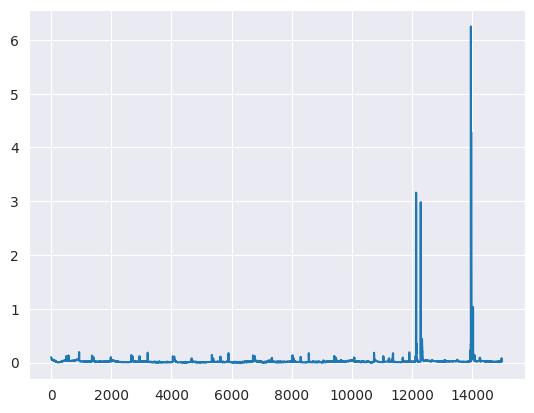

In [115]:
reconstruction_error, threshold_pca, anomalies_pca  = metrics_pca(pca, scaled_data)

## ***Isolation Forest***

In [116]:
anomaly_scores_iso, anomalies_iforest = metrics_iso_forest(scaled_data)

## ***Local Outlier Factor***

In [117]:
anomaly_scores_lof, anomalies_lof = metrics_lof(scaled_data)

## ***Combining Anomalies***

In [118]:
combined_anomalies = anomalies_pca | anomalies_iforest | anomalies_lof

In [119]:
p1_6['Anomaly'] = combined_anomalies
p1_6['Reconstruction_Error'] = reconstruction_error
p1_6['Isolation_Score'] = anomaly_scores_iso
p1_6['Lof_Score'] = anomaly_scores_lof

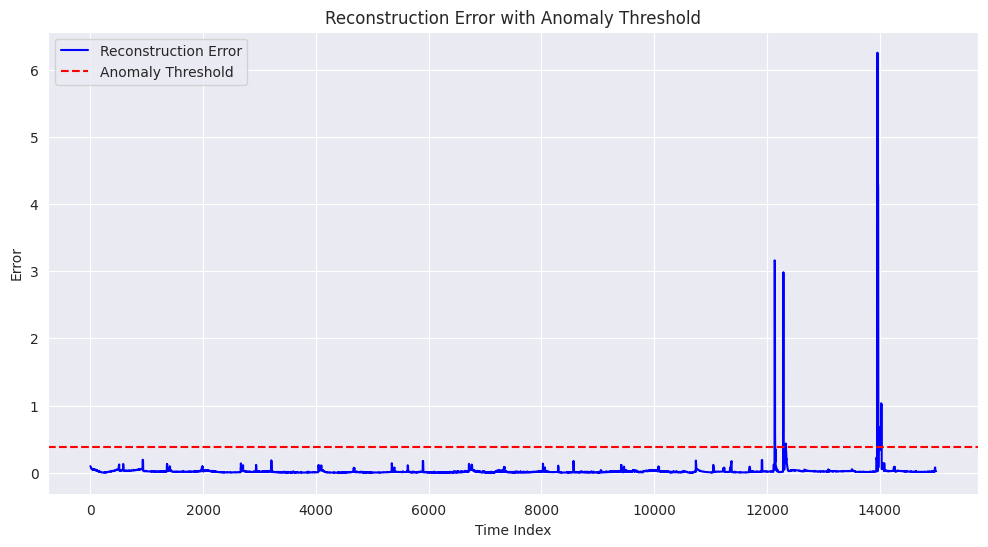

In [120]:
plot_reconstruction_error()

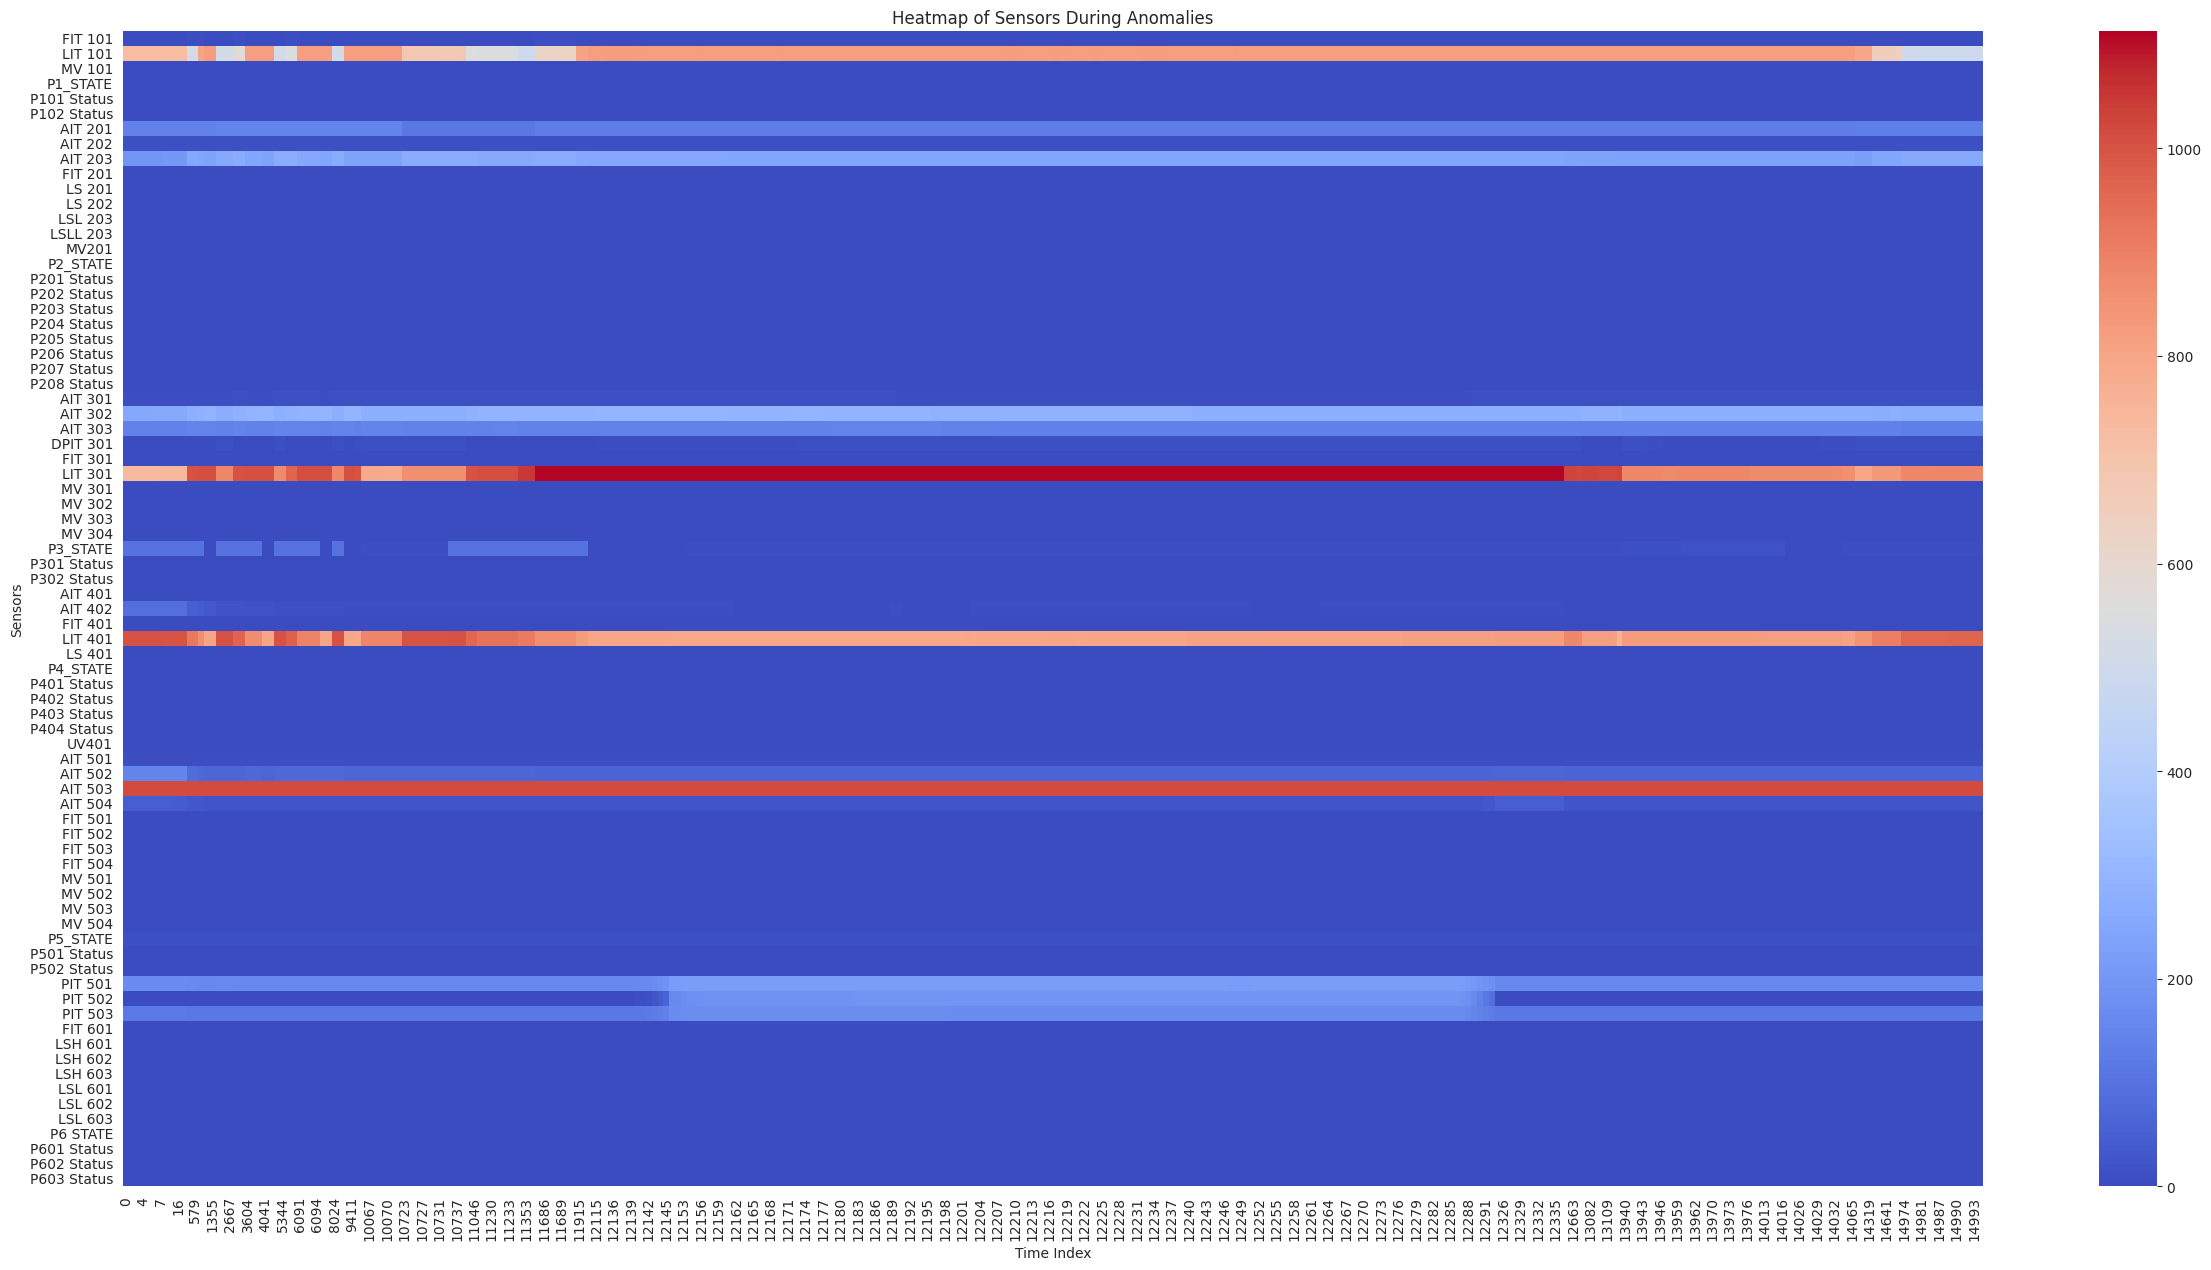

In [121]:
plot_heatmap(p1_6)

In [122]:
print(f"Total anomalies detected by PCA: {np.sum(anomalies_pca)}")
print(f"Total anomalies detected by Isolation Forest: {np.sum(anomalies_iforest)}")
print(f"Total anomalies detected by Local Outlier Factor: {np.sum(anomalies_lof)}\n\n")

check_common_anomalies_3methods(anomalies_pca, anomalies_iforest, anomalies_lof)

Total anomalies detected by PCA: 54
Total anomalies detected by Isolation Forest: 149
Total anomalies detected by Local Outlier Factor: 150


Total common anomalies detected by all methods: 4
Total common anomalies detected by PCA and Isolation Forest: 4
Total common anomalies detected by PCA and Local Outlier Factor: 28
Total common anomalies detected by Isolation Forest and Local Outlier Factor: 5


In [123]:
# Ensure labels are binary (0 for benign, 1 for attack)
true_labels = prepare_dfs([labels])

# Generate a classification report
print("Classification Report:")
print(classification_report(true_labels, p1_6['Anomaly']))

# Display confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(true_labels, p1_6['Anomaly'])
print(cm)

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     12443
           1       0.60      0.08      0.13      2553

    accuracy                           0.83     14996
   macro avg       0.72      0.53      0.52     14996
weighted avg       0.80      0.83      0.78     14996

Confusion Matrix:
[[12315   128]
 [ 2361   192]]


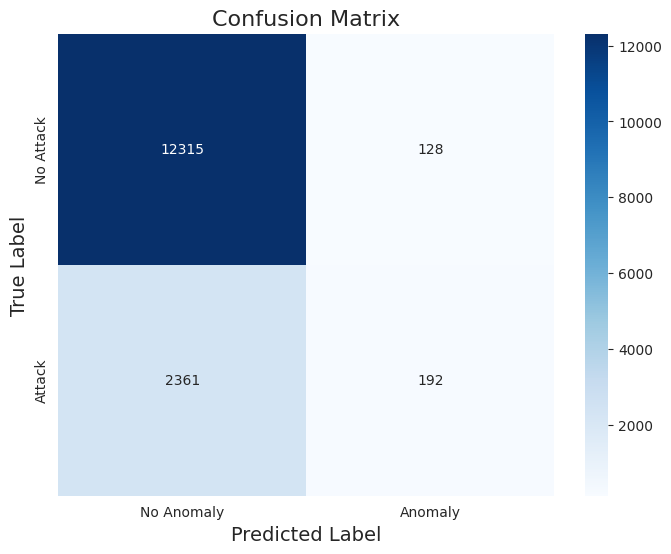

In [124]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Anomaly', 'Anomaly'], yticklabels=['No Attack', 'Attack'])
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.show()

In [125]:
metrics_pca_dict = evaluate_metrics(true_labels, anomalies_pca)
metrics_iso_forest_dict = evaluate_metrics(true_labels, anomalies_iforest)
metrics_lof_dict = evaluate_metrics(true_labels, anomalies_lof)

results = pd.DataFrame([metrics_pca_dict, metrics_iso_forest_dict, metrics_lof_dict],
                       index=["PCA", "Isolation Forest", "Local Outlier Factor"])

print(results)

                      Precision    Recall  F1-Score       MCC  \
PCA                    0.314815  0.006659  0.013042  0.023124   
Isolation Forest       0.899329  0.052487  0.099186  0.194329   
Local Outlier Factor   0.366667  0.021543  0.040696  0.052531   

                      Balanced Accuracy   AUC-PRC  
PCA                            0.501843  0.501843  
Isolation Forest               0.525641  0.525641  
Local Outlier Factor           0.506954  0.506954  


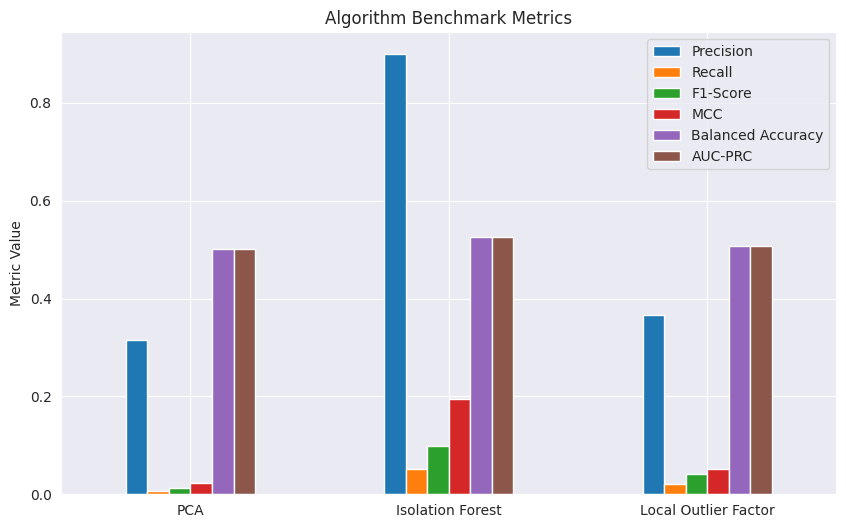

In [126]:
results.plot(kind='bar', figsize=(10, 6), title='Algorithm Benchmark Metrics')
plt.ylabel('Metric Value')
plt.xticks(rotation=0)
plt.legend(loc='upper right')
plt.show()

## ***Single Stage Multi Point (SSMP)***
Targets multiple sensors at a single point in time.

### ***Single Stage Multi Point (SSMP) - P1***

Scaled data shape: (14996, 6)
PCA Components: (14996, 4)
Number of anomalies: 105


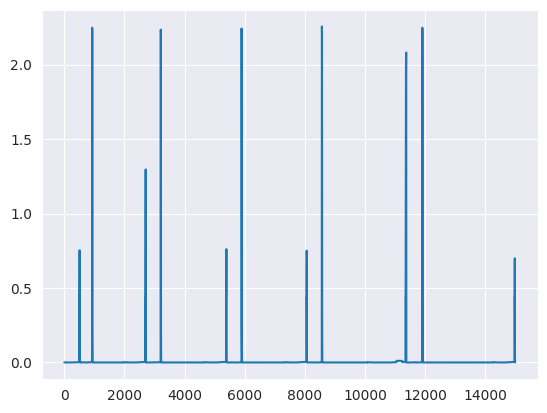

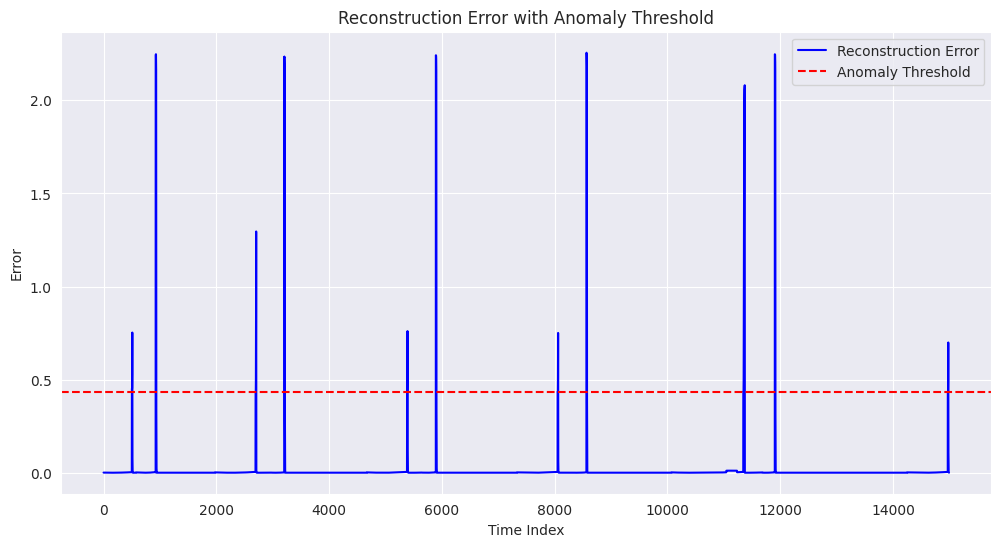

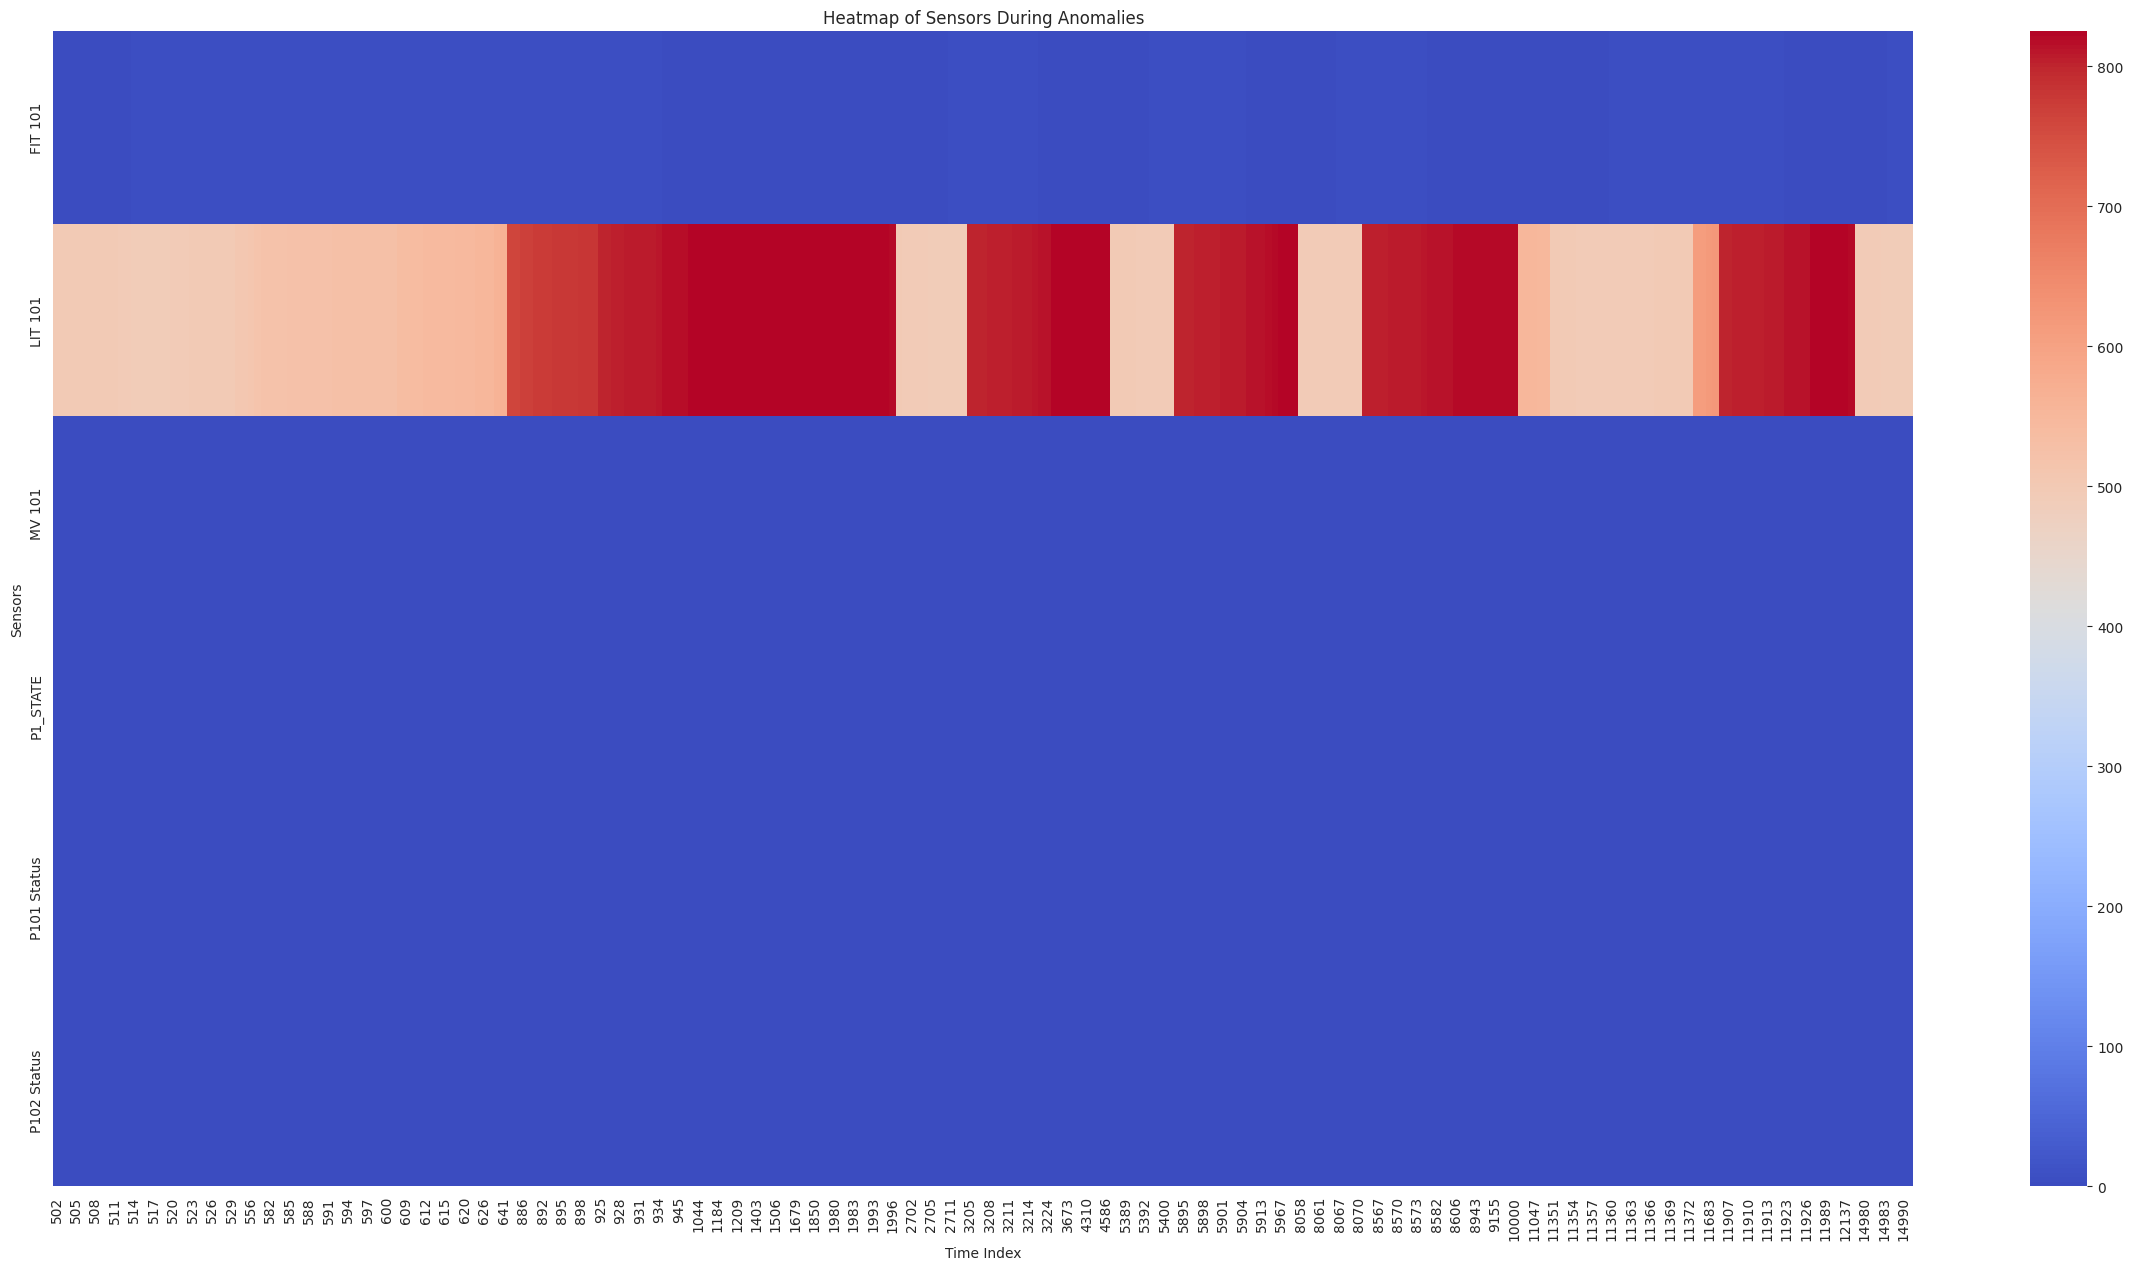

Total anomalies detected by PCA: 105
Total anomalies detected by Isolation Forest: 150
Total anomalies detected by Local Outlier Factor: 150


Total common anomalies detected by all methods: 18
Total common anomalies detected by PCA and Isolation Forest: 75
Total common anomalies detected by PCA and Local Outlier Factor: 33
Total common anomalies detected by Isolation Forest and Local Outlier Factor: 28


In [127]:
p1 = prepare_dfs([p1_])
scaled_data = scale_data(p1)

#### ***PCA***
pca_components, pca = pca_(scaled_data)
reconstruction_error, threshold_pca, anomalies_pca = metrics_pca(pca, scaled_data)

#### ***Isolation Forest***
anomaly_scores_iso, anomalies_iforest = metrics_iso_forest(scaled_data)

#### ***Local Outlier Factor***
anomaly_scores_lof, anomalies_lof = metrics_lof(scaled_data)

#### ***Combining Anomalies***
combined_anomalies = anomalies_pca | anomalies_iforest | anomalies_lof

p1['Anomaly'] = combined_anomalies
p1['Reconstruction_Error'] = reconstruction_error
p1['Isolation_Score'] = anomaly_scores_iso
p1['Lof_Score'] = anomaly_scores_lof

plot_reconstruction_error()
plot_heatmap(p1)

print(f"Total anomalies detected by PCA: {np.sum(anomalies_pca)}")
print(f"Total anomalies detected by Isolation Forest: {np.sum(anomalies_iforest)}")
print(f"Total anomalies detected by Local Outlier Factor: {np.sum(anomalies_lof)}\n\n")

check_common_anomalies_3methods(anomalies_pca, anomalies_iforest, anomalies_lof)

### ***Single Stage Multi Point (SSMP) - P2***

Scaled data shape: (14996, 18)
PCA Components: (14996, 3)
Number of anomalies: 191


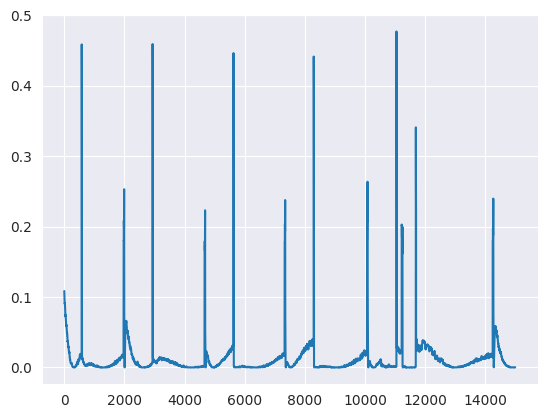

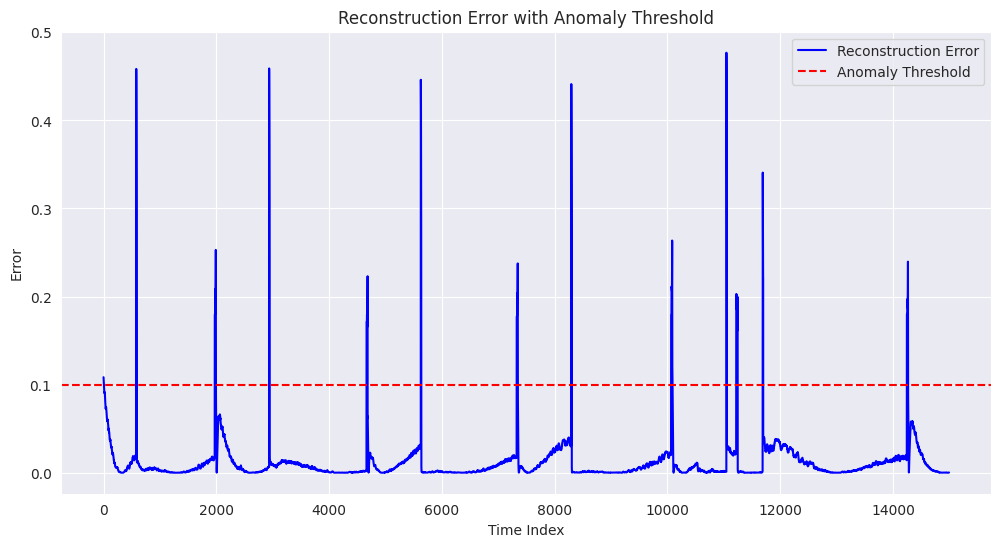

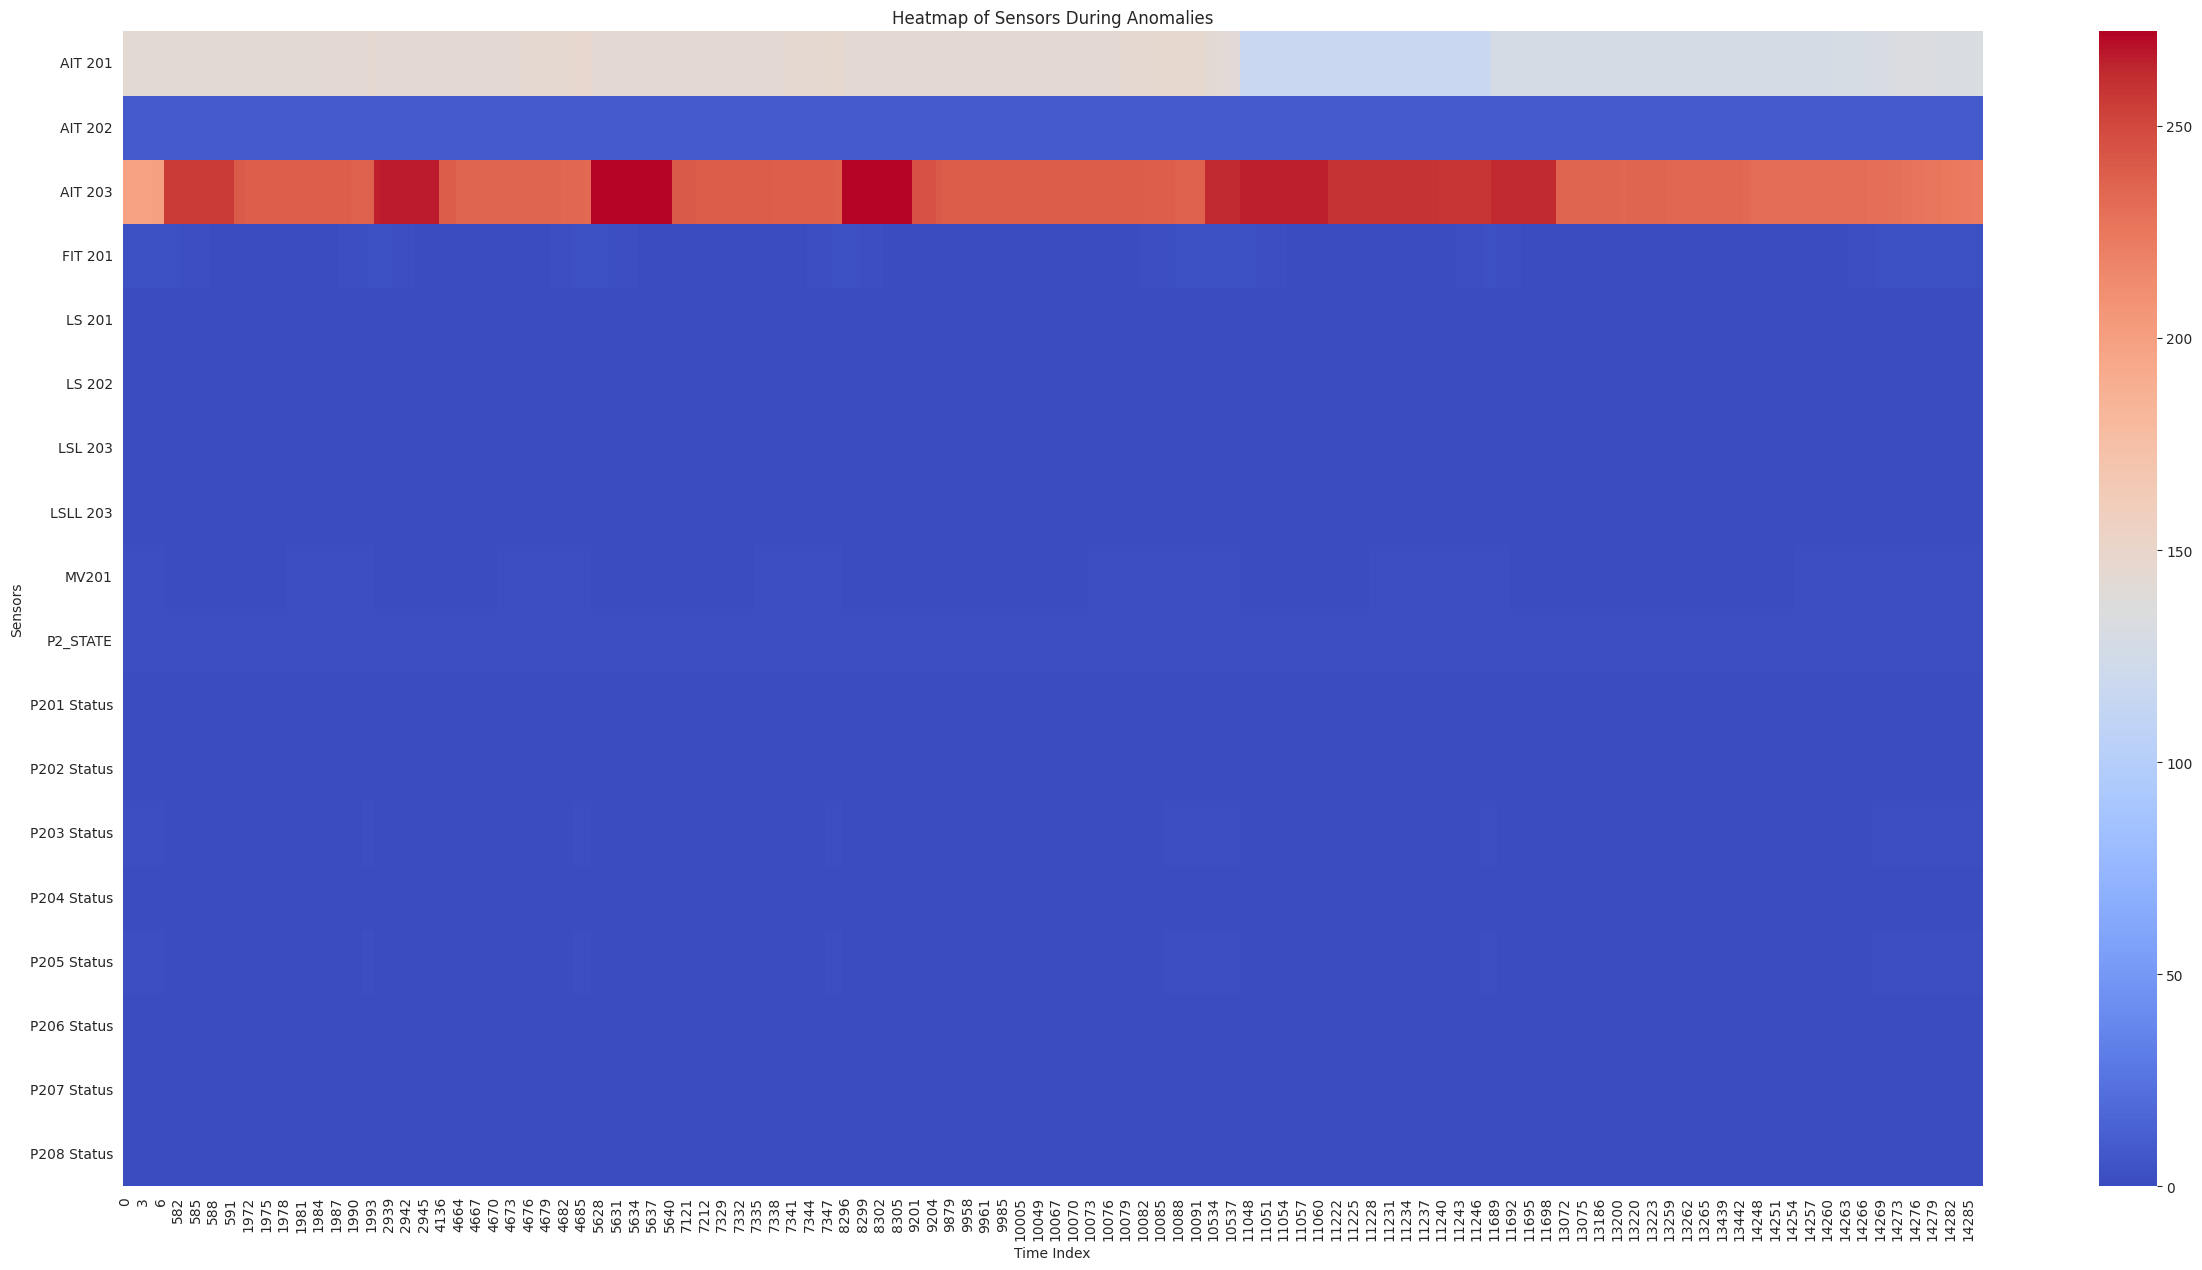

Total anomalies detected by PCA: 191
Total anomalies detected by Isolation Forest: 150
Total anomalies detected by Local Outlier Factor: 150


Total common anomalies detected by all methods: 29
Total common anomalies detected by PCA and Isolation Forest: 109
Total common anomalies detected by PCA and Local Outlier Factor: 49
Total common anomalies detected by Isolation Forest and Local Outlier Factor: 44


In [128]:
p2 = prepare_dfs([p2_])
scaled_data = scale_data(p2)

#### ***PCA***
pca_components, pca = pca_(scaled_data)
reconstruction_error, threshold_pca, anomalies_pca = metrics_pca(pca, scaled_data)

#### ***Isolation Forest***
anomaly_scores_iso, anomalies_iforest = metrics_iso_forest(scaled_data)

#### ***Local Outlier Factor***
anomaly_scores_lof, anomalies_lof = metrics_lof(scaled_data)

#### ***Combining Anomalies***
combined_anomalies = anomalies_pca | anomalies_iforest | anomalies_lof

p2['Anomaly'] = combined_anomalies
p2['Reconstruction_Error'] = reconstruction_error
p2['Isolation_Score'] = anomaly_scores_iso
p2['Lof_Score'] = anomaly_scores_lof

plot_reconstruction_error()
plot_heatmap(p2)

print(f"Total anomalies detected by PCA: {np.sum(anomalies_pca)}")
print(f"Total anomalies detected by Isolation Forest: {np.sum(anomalies_iforest)}")
print(f"Total anomalies detected by Local Outlier Factor: {np.sum(anomalies_lof)}\n\n")

check_common_anomalies_3methods(anomalies_pca, anomalies_iforest, anomalies_lof)

### ***Single Stage Multi Point (SSMP) - P3***

Scaled data shape: (14996, 13)
PCA Components: (14996, 7)
Number of anomalies: 213


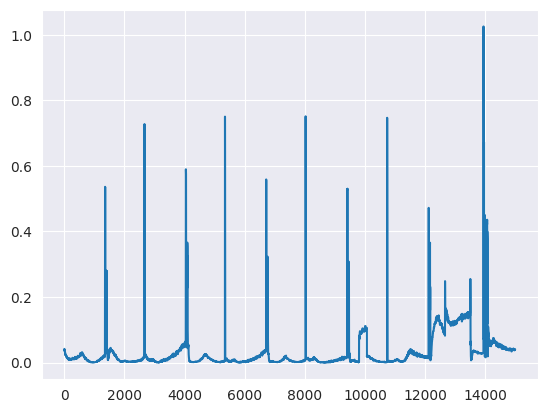

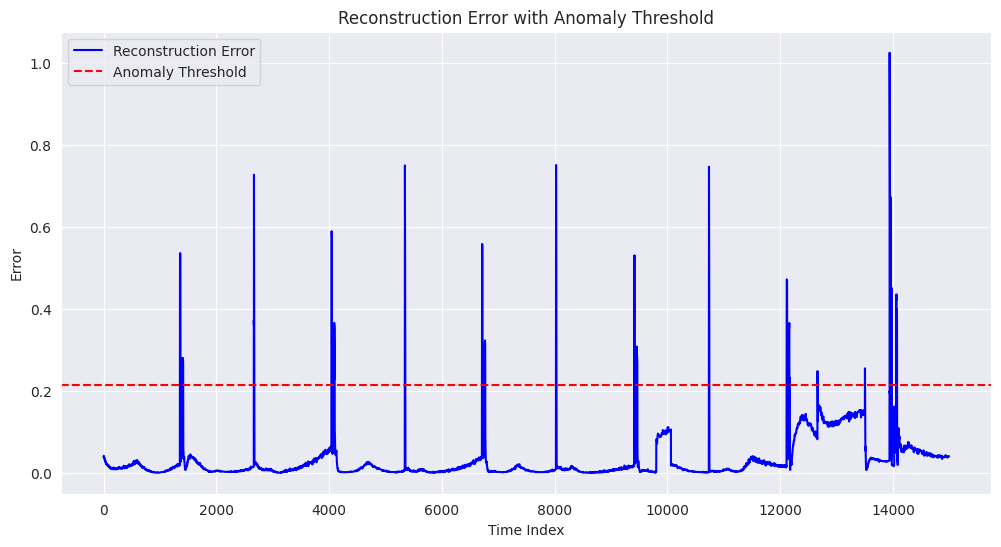

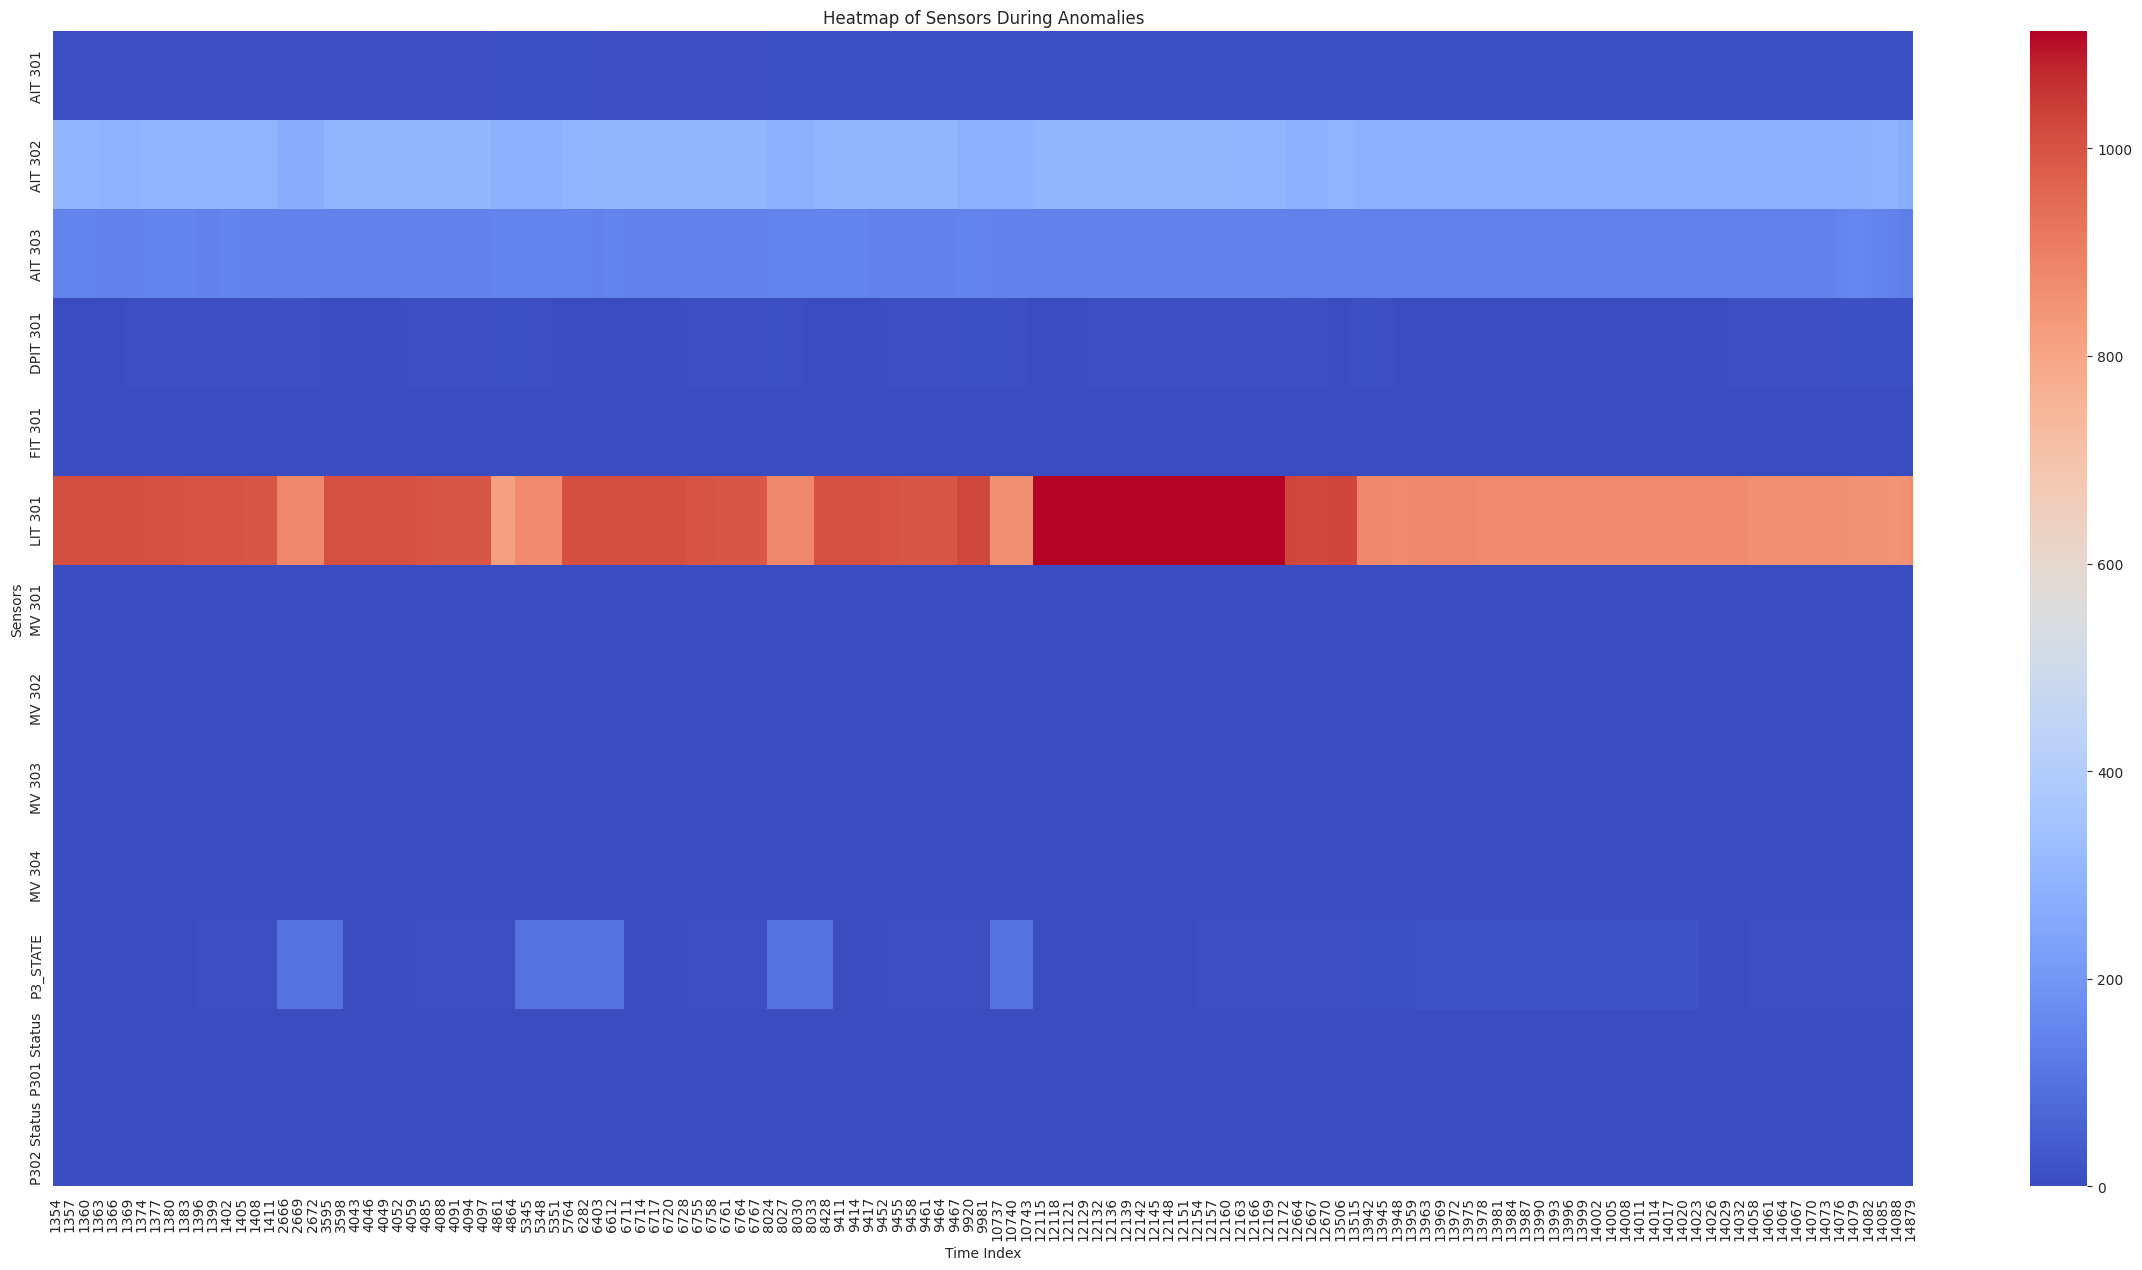

Total anomalies detected by PCA: 213
Total anomalies detected by Isolation Forest: 150
Total anomalies detected by Local Outlier Factor: 150


Total common anomalies detected by all methods: 24
Total common anomalies detected by PCA and Isolation Forest: 56
Total common anomalies detected by PCA and Local Outlier Factor: 56
Total common anomalies detected by Isolation Forest and Local Outlier Factor: 34


In [129]:
p3 = prepare_dfs([p3_])
scaled_data = scale_data(p3)

#### ***PCA***
pca_components, pca = pca_(scaled_data)
reconstruction_error, threshold_pca, anomalies_pca = metrics_pca(pca, scaled_data)

#### ***Isolation Forest***
anomaly_scores_iso, anomalies_iforest = metrics_iso_forest(scaled_data)

#### ***Local Outlier Factor***
anomaly_scores_lof, anomalies_lof = metrics_lof(scaled_data)

#### ***Combining Anomalies***
combined_anomalies = anomalies_pca | anomalies_iforest | anomalies_lof

p3['Anomaly'] = combined_anomalies
p3['Reconstruction_Error'] = reconstruction_error
p3['Isolation_Score'] = anomaly_scores_iso
p3['Lof_Score'] = anomaly_scores_lof

plot_reconstruction_error()
plot_heatmap(p3)

print(f"Total anomalies detected by PCA: {np.sum(anomalies_pca)}")
print(f"Total anomalies detected by Isolation Forest: {np.sum(anomalies_iforest)}")
print(f"Total anomalies detected by Local Outlier Factor: {np.sum(anomalies_lof)}\n\n")

check_common_anomalies_3methods(anomalies_pca, anomalies_iforest, anomalies_lof)

### ***Single Stage Multi Point (SSMP) - P4***

Scaled data shape: (14996, 11)
PCA Components: (14996, 4)
Number of anomalies: 12


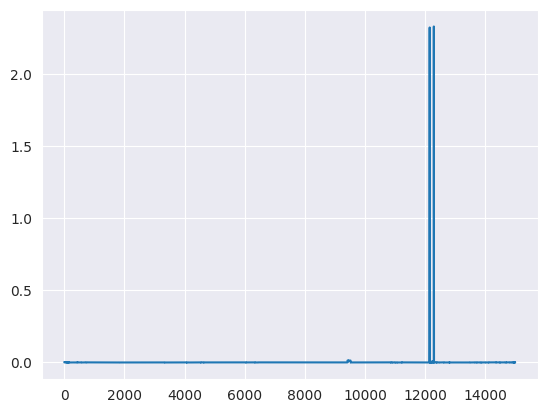

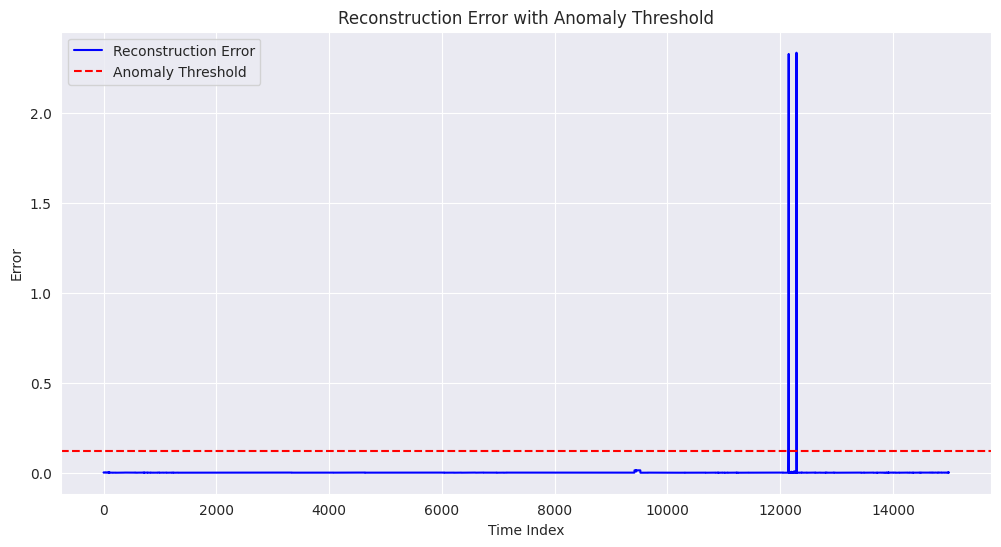

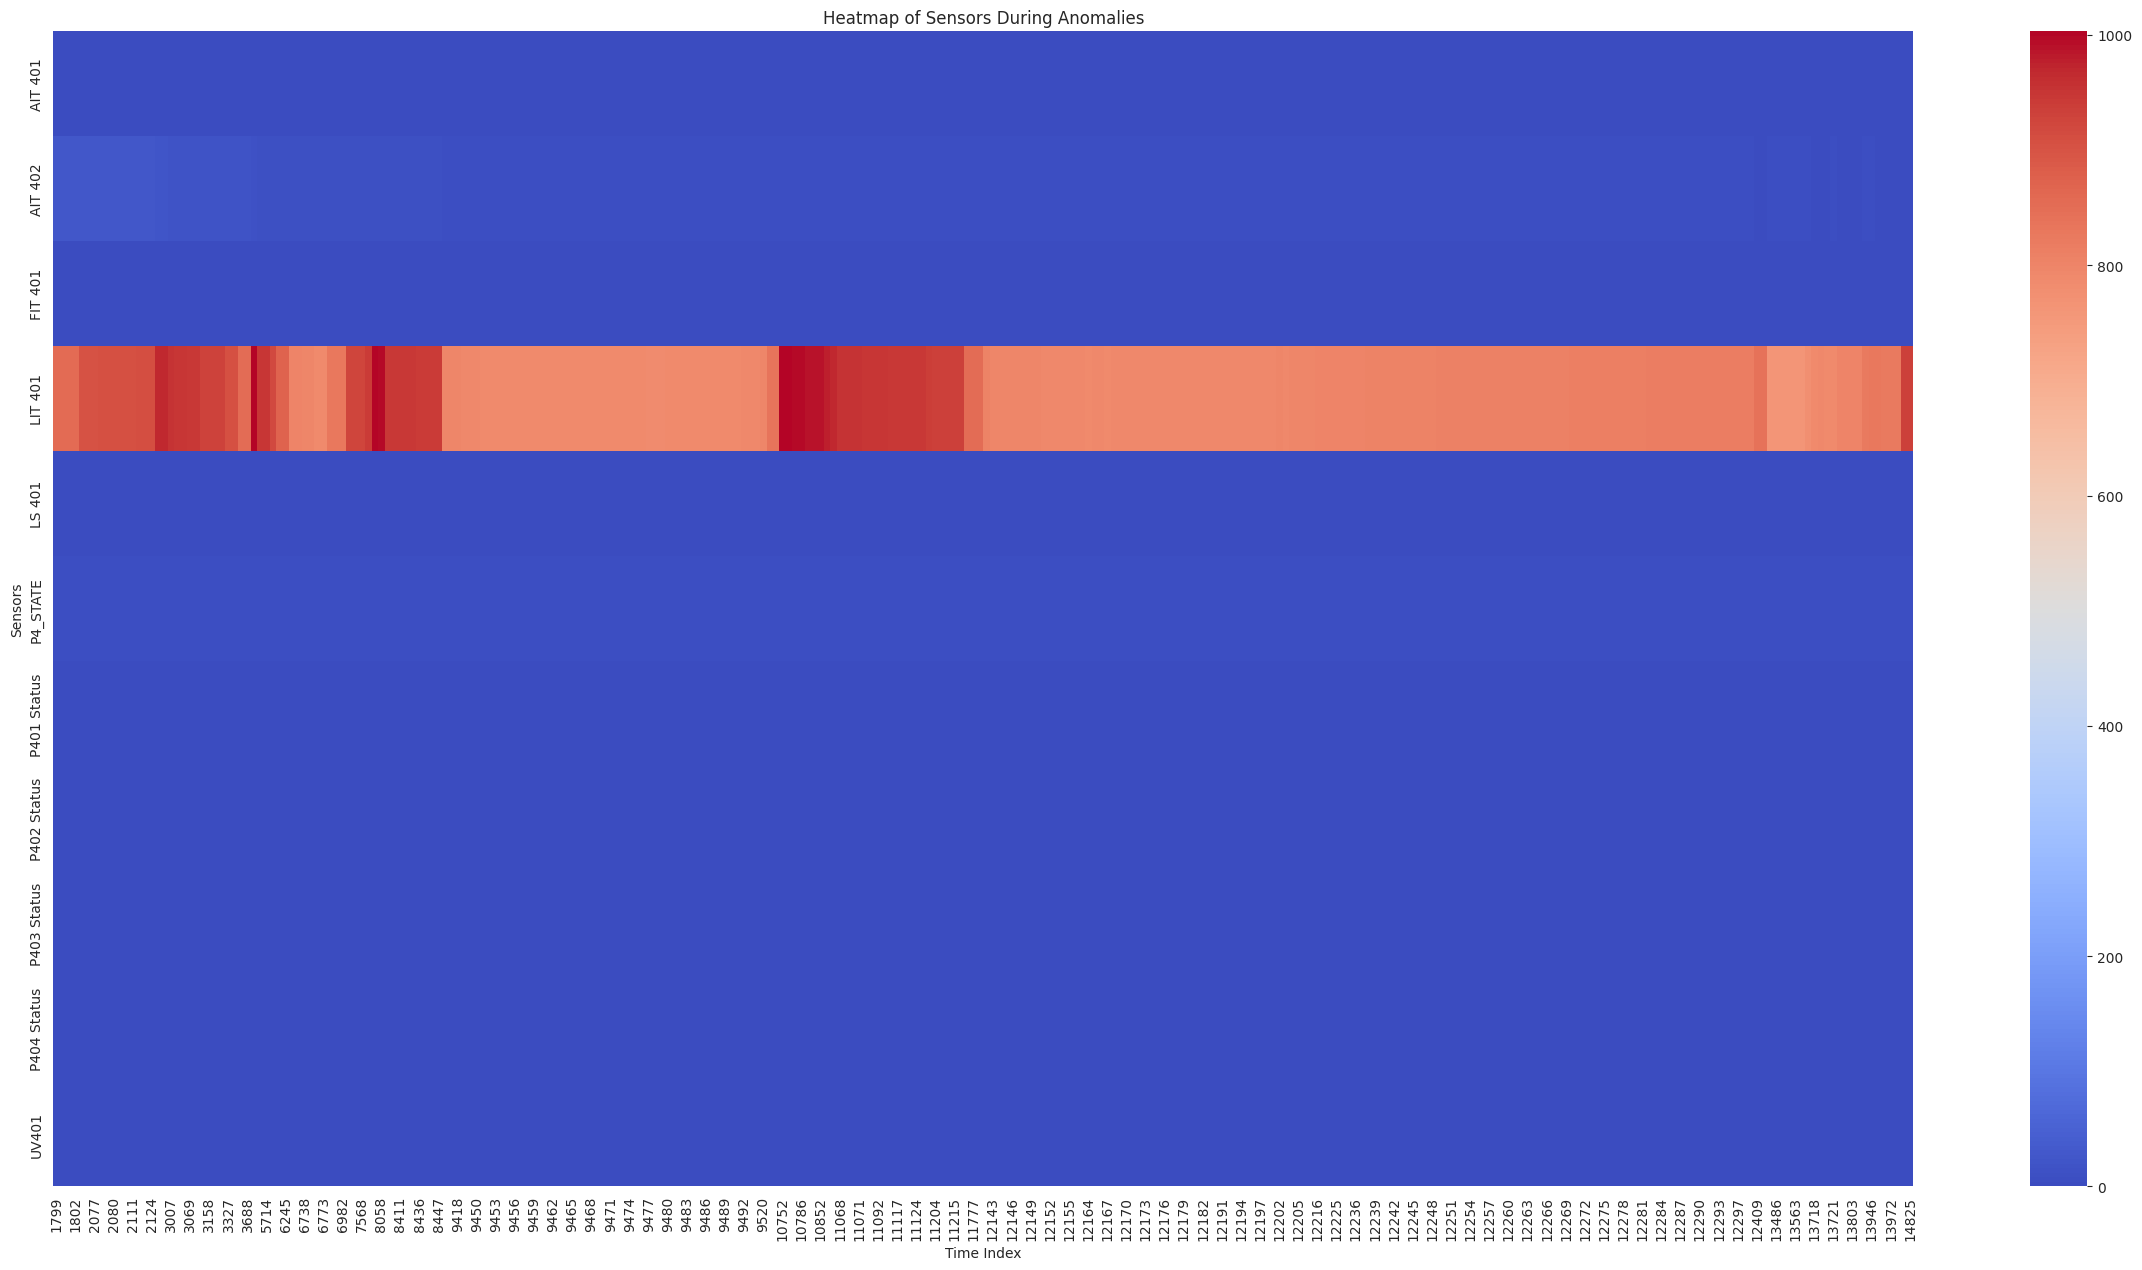

Total anomalies detected by PCA: 12
Total anomalies detected by Isolation Forest: 147
Total anomalies detected by Local Outlier Factor: 150


Total common anomalies detected by all methods: 0
Total common anomalies detected by PCA and Isolation Forest: 0
Total common anomalies detected by PCA and Local Outlier Factor: 12
Total common anomalies detected by Isolation Forest and Local Outlier Factor: 5


In [130]:
p4 = prepare_dfs([p4_])
scaled_data = scale_data(p4)

#### ***PCA***
pca_components, pca = pca_(scaled_data)
reconstruction_error, threshold_pca, anomalies_pca = metrics_pca(pca, scaled_data)

#### ***Isolation Forest***
anomaly_scores_iso, anomalies_iforest = metrics_iso_forest(scaled_data)

#### ***Local Outlier Factor***
anomaly_scores_lof, anomalies_lof = metrics_lof(scaled_data)

#### ***Combining Anomalies***
combined_anomalies = anomalies_pca | anomalies_iforest | anomalies_lof

p4['Anomaly'] = combined_anomalies
p4['Reconstruction_Error'] = reconstruction_error
p4['Isolation_Score'] = anomaly_scores_iso
p4['Lof_Score'] = anomaly_scores_lof

plot_reconstruction_error()
plot_heatmap(p4)

print(f"Total anomalies detected by PCA: {np.sum(anomalies_pca)}")
print(f"Total anomalies detected by Isolation Forest: {np.sum(anomalies_iforest)}")
print(f"Total anomalies detected by Local Outlier Factor: {np.sum(anomalies_lof)}\n\n")

check_common_anomalies_3methods(anomalies_pca, anomalies_iforest, anomalies_lof)

### ***Single Stage Multi Point (SSMP) - P5***

Scaled data shape: (14996, 18)
PCA Components: (14996, 5)
Number of anomalies: 43


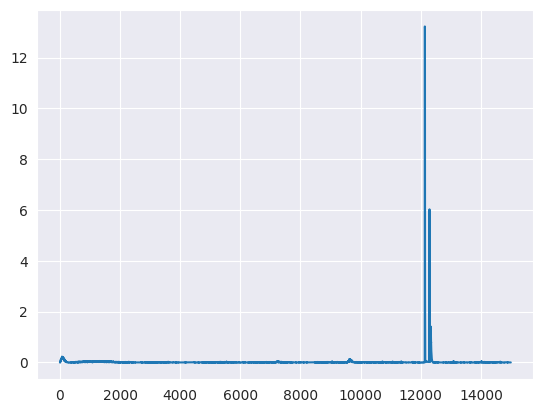

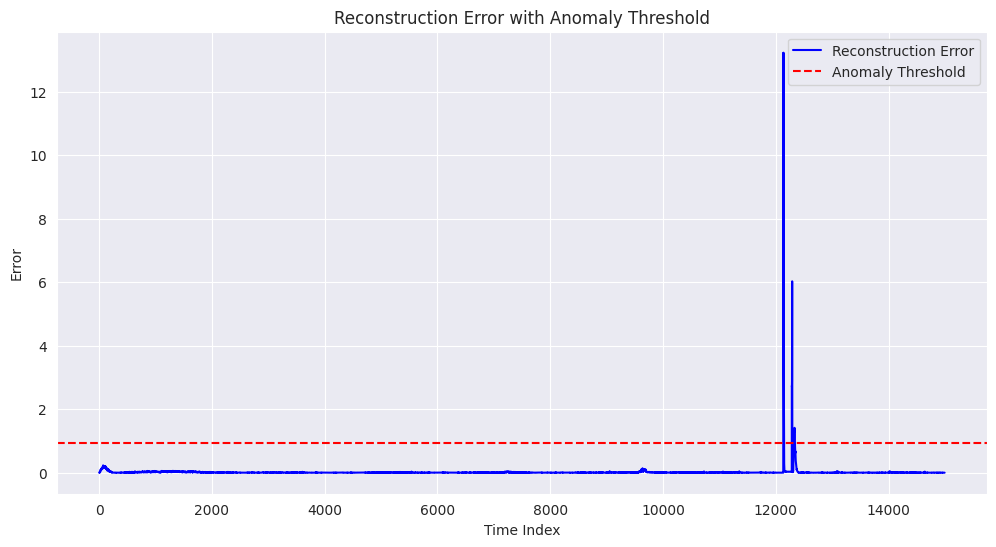

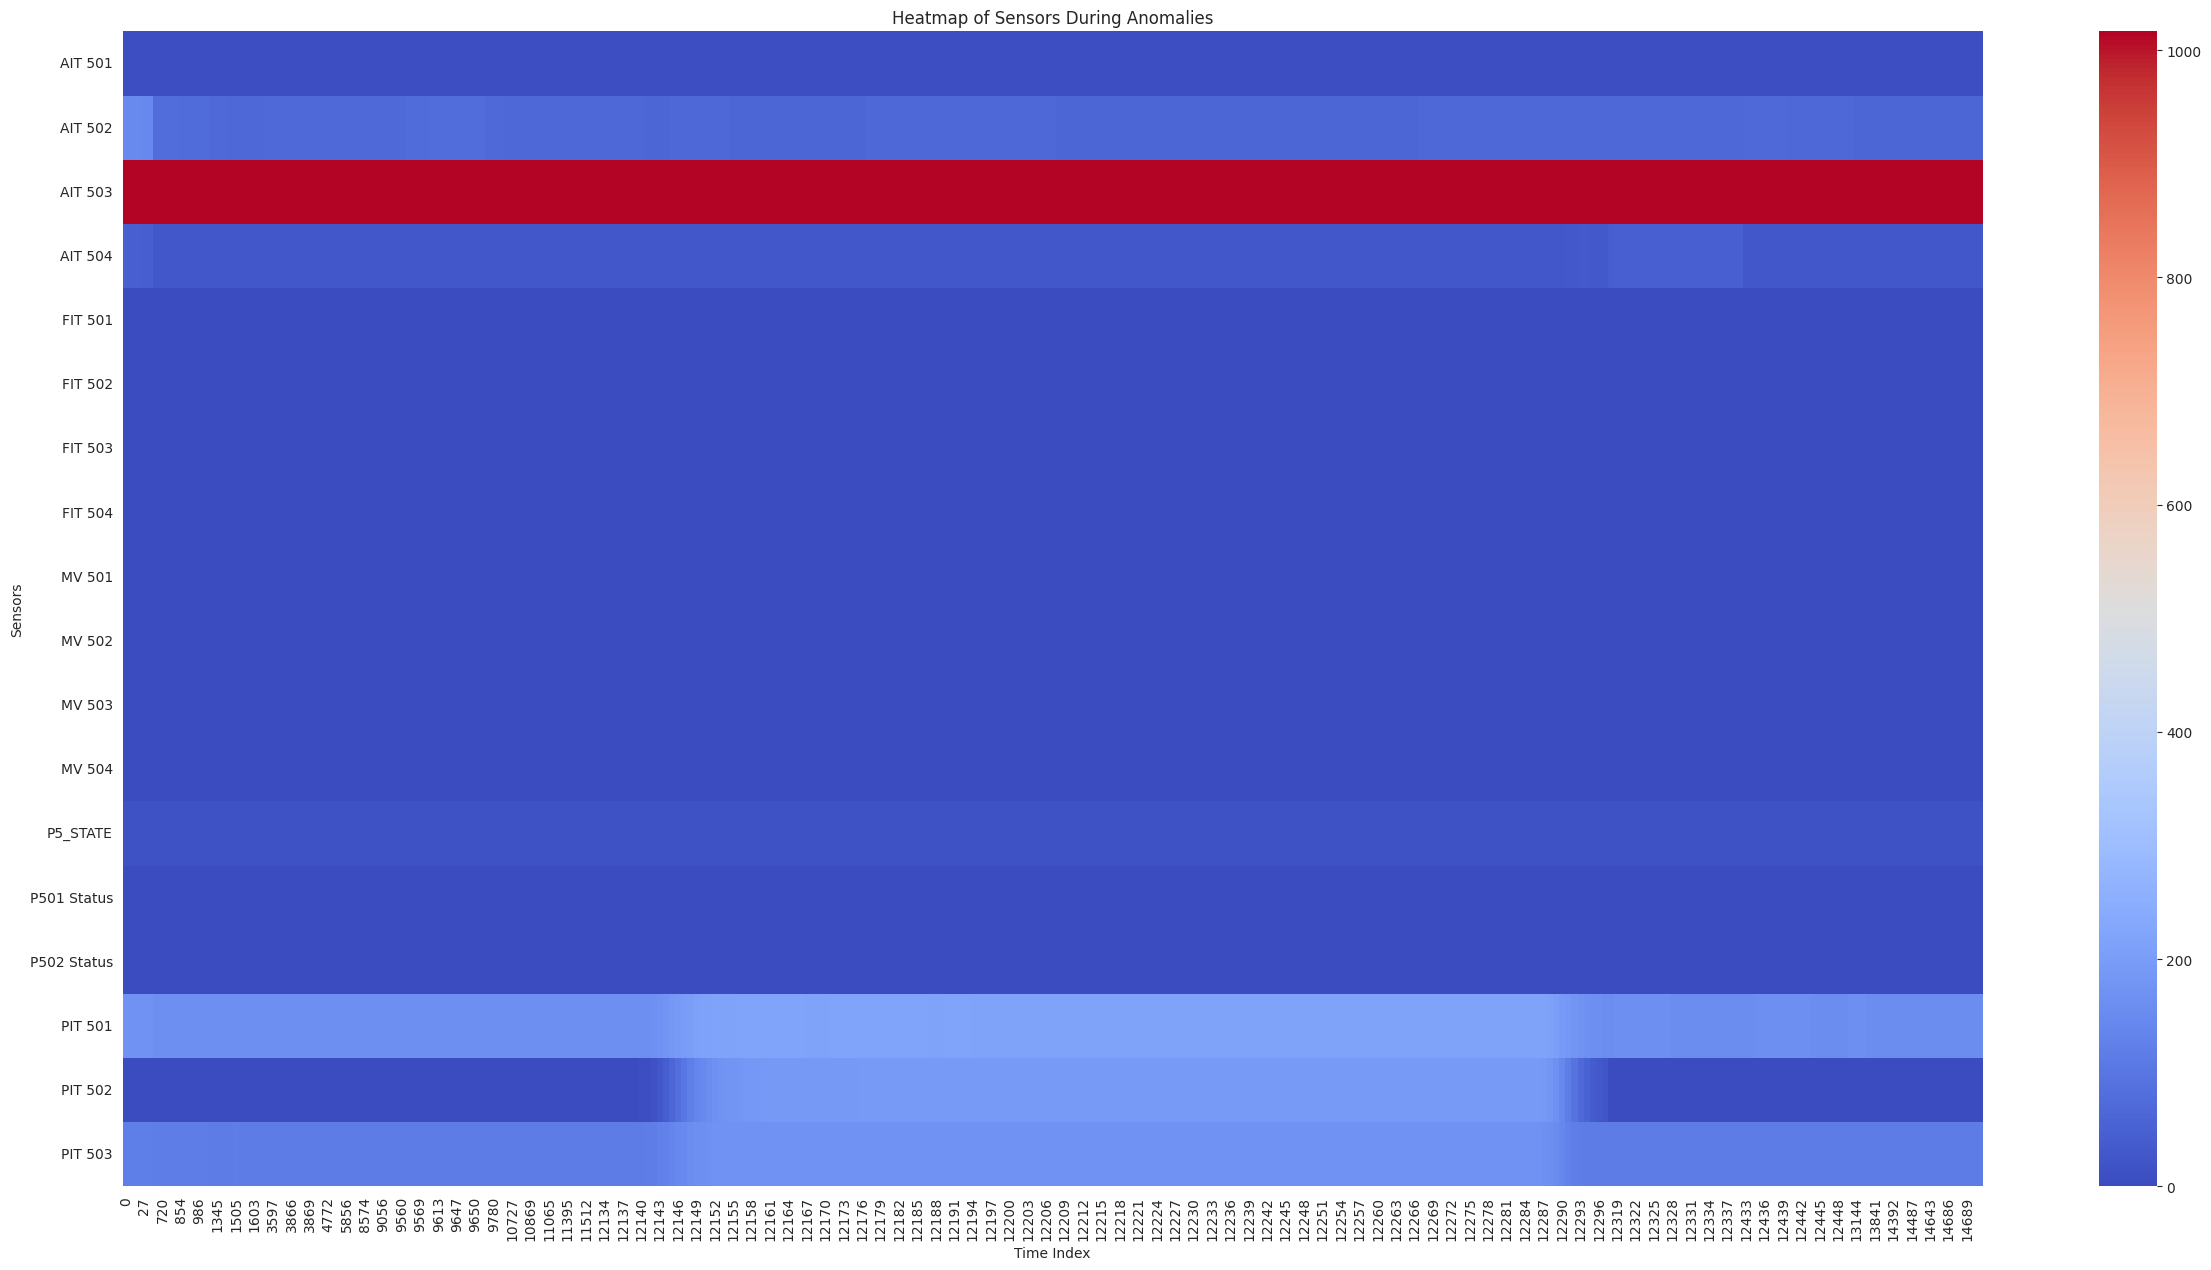

Total anomalies detected by PCA: 43
Total anomalies detected by Isolation Forest: 149
Total anomalies detected by Local Outlier Factor: 150


Total common anomalies detected by all methods: 6
Total common anomalies detected by PCA and Isolation Forest: 6
Total common anomalies detected by PCA and Local Outlier Factor: 20
Total common anomalies detected by Isolation Forest and Local Outlier Factor: 19


In [131]:
p5 = prepare_dfs([p5_])
scaled_data = scale_data(p5)

#### ***PCA***
pca_components, pca = pca_(scaled_data)
reconstruction_error, threshold_pca, anomalies_pca = metrics_pca(pca, scaled_data)

#### ***Isolation Forest***
anomaly_scores_iso, anomalies_iforest = metrics_iso_forest(scaled_data)

#### ***Local Outlier Factor***
anomaly_scores_lof, anomalies_lof = metrics_lof(scaled_data)

#### ***Combining Anomalies***
combined_anomalies = anomalies_pca | anomalies_iforest | anomalies_lof

p5['Anomaly'] = combined_anomalies
p5['Reconstruction_Error'] = reconstruction_error
p5['Isolation_Score'] = anomaly_scores_iso
p5['Lof_Score'] = anomaly_scores_lof

plot_reconstruction_error()
plot_heatmap(p5)

print(f"Total anomalies detected by PCA: {np.sum(anomalies_pca)}")
print(f"Total anomalies detected by Isolation Forest: {np.sum(anomalies_iforest)}")
print(f"Total anomalies detected by Local Outlier Factor: {np.sum(anomalies_lof)}\n\n")

check_common_anomalies_3methods(anomalies_pca, anomalies_iforest, anomalies_lof)

### ***Single Stage Multi Point (SSMP) - P6***

Scaled data shape: (14996, 11)
PCA Components: (14996, 3)
Number of anomalies: 1


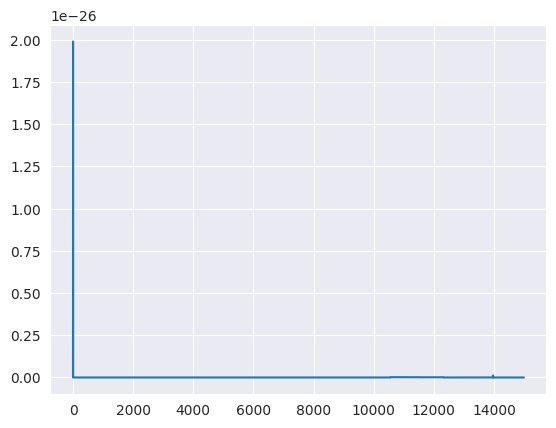

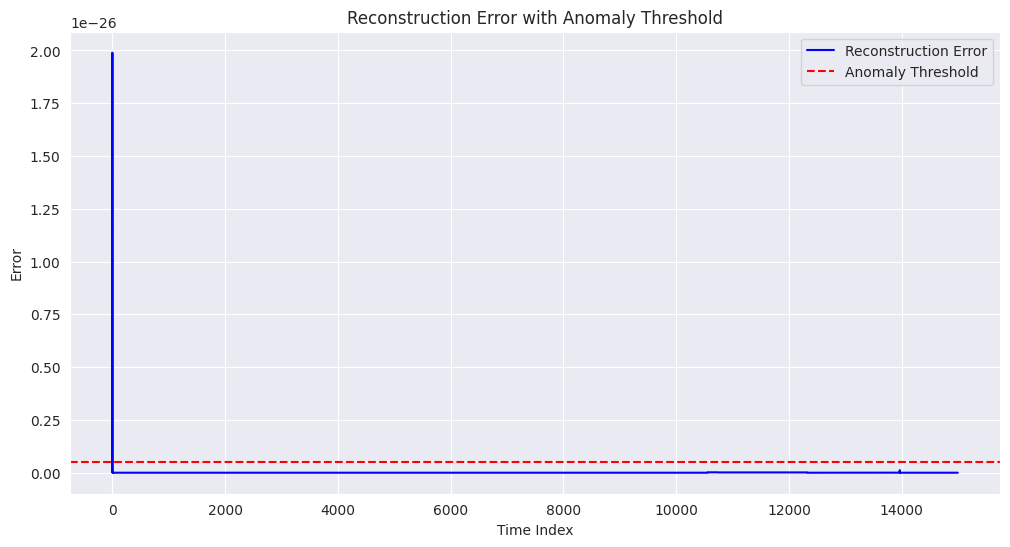

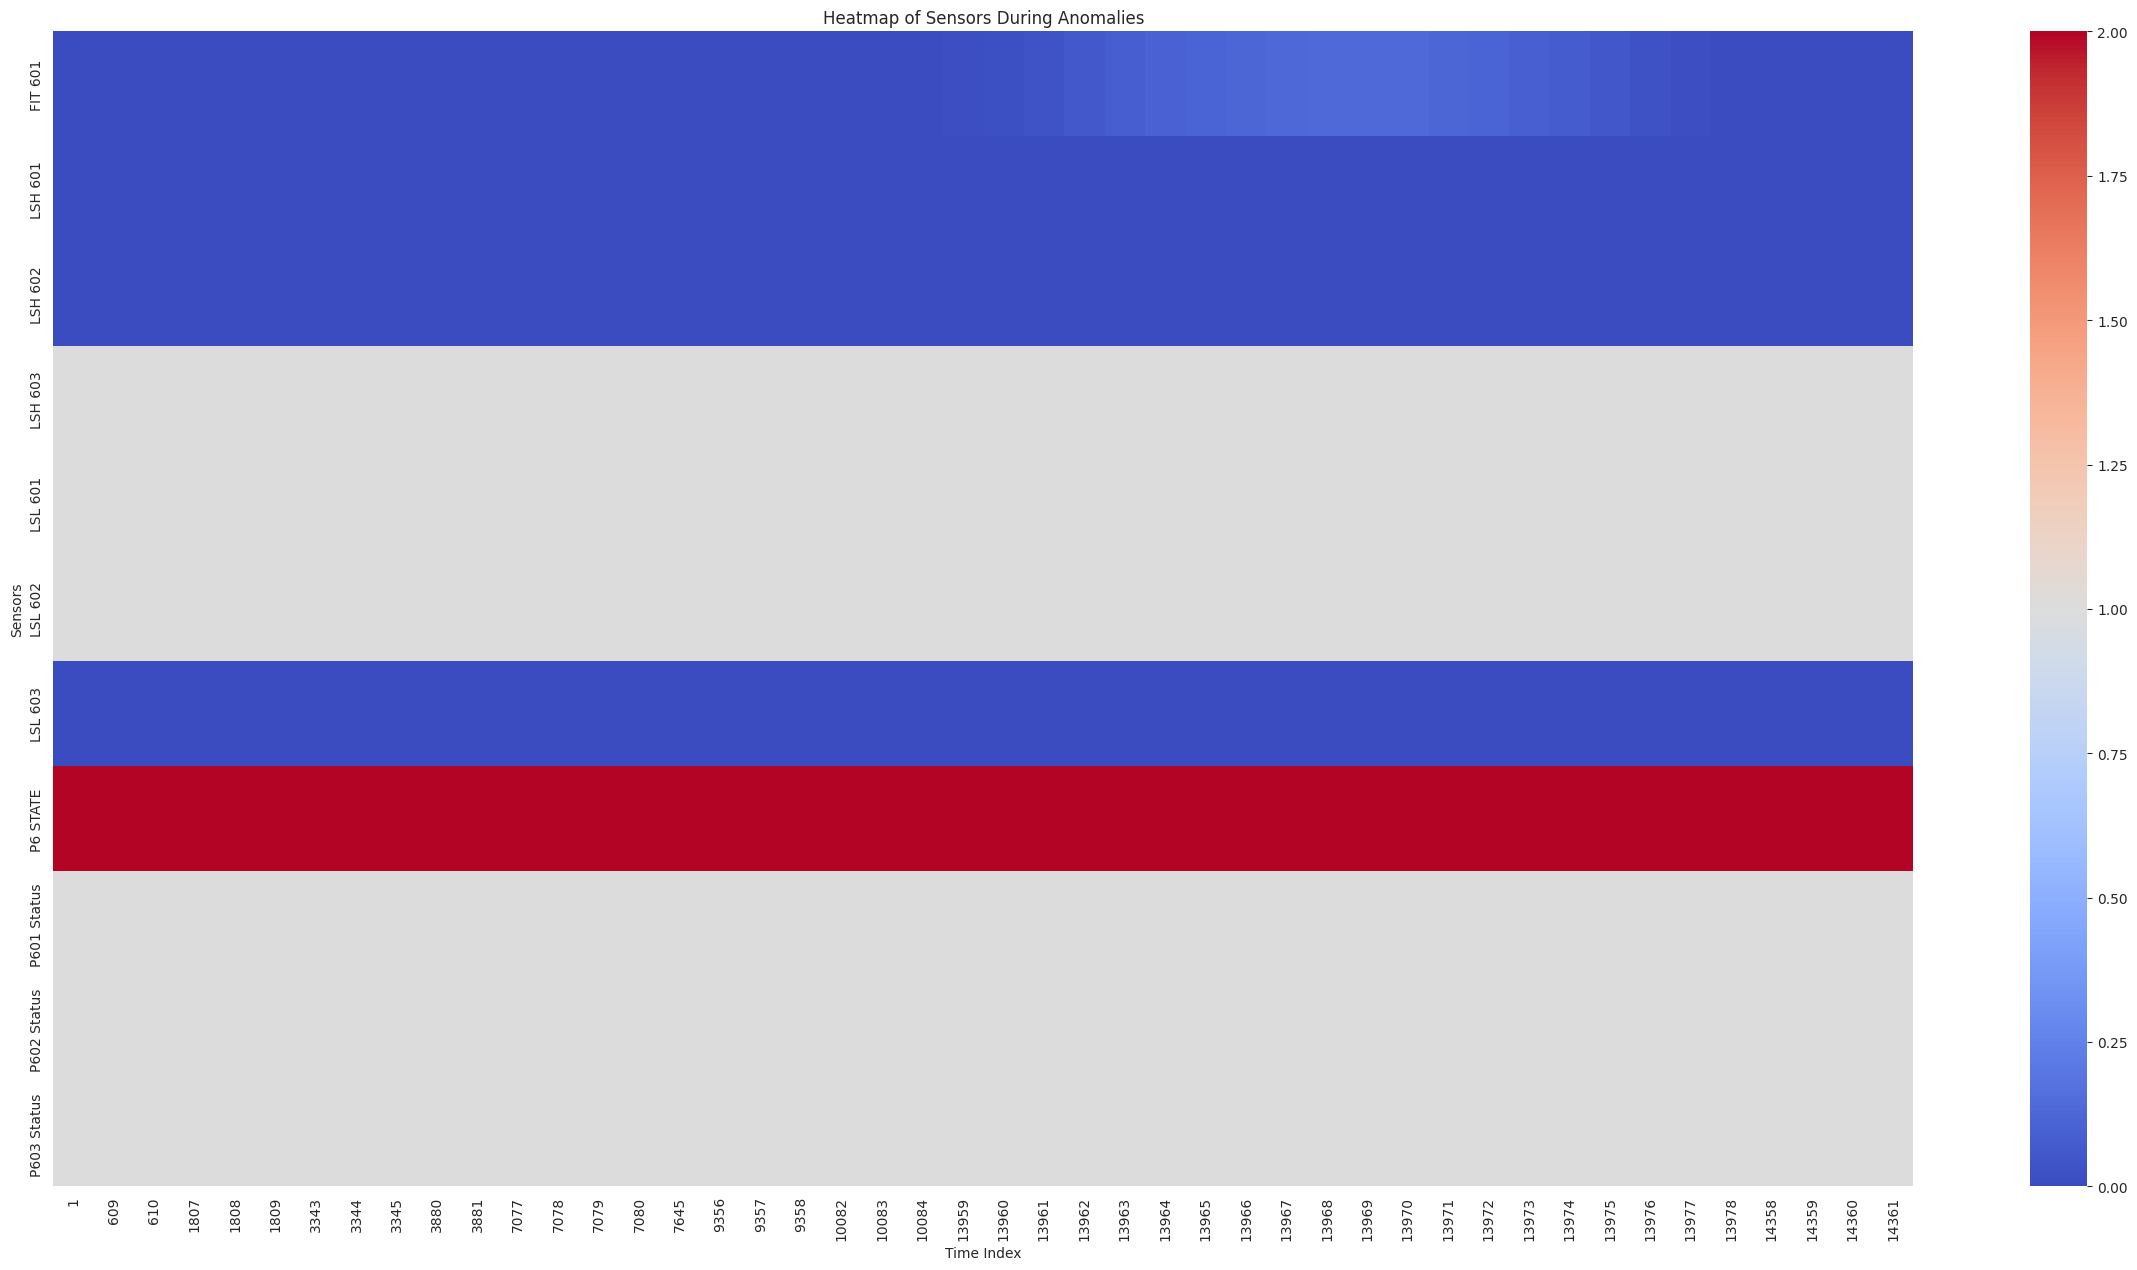

Total anomalies detected by PCA: 1
Total anomalies detected by Isolation Forest: 0
Total anomalies detected by Local Outlier Factor: 45


Total common anomalies detected by all methods: 0
Total common anomalies detected by PCA and Isolation Forest: 0
Total common anomalies detected by PCA and Local Outlier Factor: 0
Total common anomalies detected by Isolation Forest and Local Outlier Factor: 0


In [132]:
p6 = prepare_dfs([p6_])
scaled_data = scale_data(p6)

#### ***PCA***
pca_components, pca = pca_(scaled_data)
reconstruction_error, threshold_pca, anomalies_pca = metrics_pca(pca, scaled_data)

#### ***Isolation Forest***
anomaly_scores_iso, anomalies_iforest = metrics_iso_forest(scaled_data)

#### ***Local Outlier Factor***
anomaly_scores_lof, anomalies_lof = metrics_lof(scaled_data)

#### ***Combining Anomalies***
combined_anomalies = anomalies_pca | anomalies_iforest | anomalies_lof

p6['Anomaly'] = combined_anomalies
p6['Reconstruction_Error'] = reconstruction_error
p6['Isolation_Score'] = anomaly_scores_iso
p6['Lof_Score'] = anomaly_scores_lof

plot_reconstruction_error()
plot_heatmap(p6)

print(f"Total anomalies detected by PCA: {np.sum(anomalies_pca)}")
print(f"Total anomalies detected by Isolation Forest: {np.sum(anomalies_iforest)}")
print(f"Total anomalies detected by Local Outlier Factor: {np.sum(anomalies_lof)}\n\n")

check_common_anomalies_3methods(anomalies_pca, anomalies_iforest, anomalies_lof)

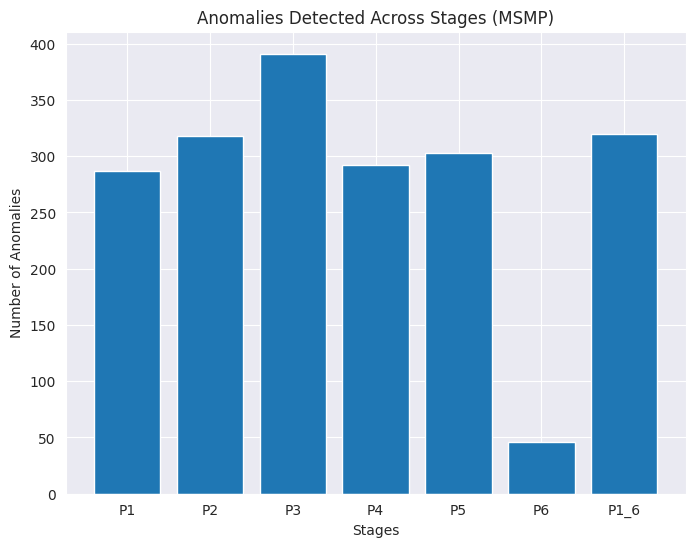

In [133]:
# Count anomalies per stage
anomalies_count = {
    "P1": np.sum(p1['Anomaly']),
    "P2": np.sum(p2['Anomaly']),
    "P3": np.sum(p3['Anomaly']),
    "P4": np.sum(p4['Anomaly']),
    "P5": np.sum(p5['Anomaly']),
    "P6": np.sum(p6['Anomaly']),
    "P1_6": np.sum(p1_6['Anomaly'])
}

# Visualize
plt.figure(figsize=(8, 6))
plt.bar(anomalies_count.keys(), anomalies_count.values())
plt.title('Anomalies Detected Across Stages (MSMP)')
plt.ylabel('Number of Anomalies')
plt.xlabel('Stages')
plt.show()


In [134]:
combined_anomalies = (
    p1['Anomaly'] | p2['Anomaly'] | p3['Anomaly'] | 
    p4['Anomaly'] | p5['Anomaly'] | p6['Anomaly']
)
total_anomalies = combined_anomalies


In [135]:
print("Total counted anomalies combined, ", total_anomalies.sum())

Total counted anomalies combined,  1396


In [136]:
# Generate a classification report
print("Classification Report:")
print(classification_report(true_labels, total_anomalies))

# Display confusion matrix
print("Confusion Matrix:")
cm_combined = confusion_matrix(true_labels, total_anomalies)
print(cm_combined)

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.92      0.88     12443
           1       0.31      0.17      0.22      2553

    accuracy                           0.79     14996
   macro avg       0.57      0.54      0.55     14996
weighted avg       0.75      0.79      0.77     14996

Confusion Matrix:
[[11474   969]
 [ 2126   427]]


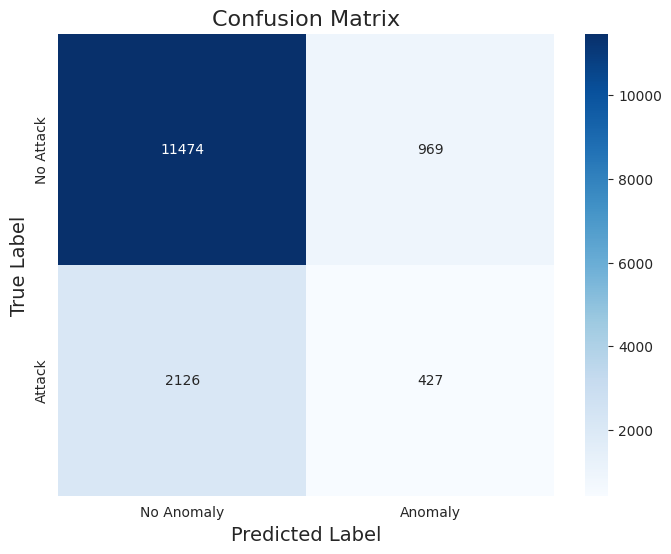

In [137]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_combined, annot=True, fmt='d', cmap='Blues', xticklabels=['No Anomaly', 'Anomaly'], yticklabels=['No Attack', 'Attack'])
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.show()

# ***Attack types***

Total number of attacks: 36.

-> ça vient du papier..

In [138]:
# Combine anomaly results
df_for_mlp = prepare_dfs([labels, p1_, p2_, p3_, p4_, p5_, p6_])

In [139]:
df_for_mlp.head()

,Label,FIT 101,LIT 101,MV 101,P1_STATE,P101 Status,P102 Status,AIT 201,AIT 202,AIT 203,...,LSH 601,LSH 602,LSH 603,LSL 601,LSL 602,LSL 603,P6 STATE,P601 Status,P602 Status,P603 Status
0,0,0.0,729.8658,1,3,2,1,142.527557,9.293002,198.077423,...,0,0,1,1,1,0,2,1,1,1
1,0,0.0,729.4340,1,3,2,1,142.527557,9.293002,198.385025,...,0,0,1,1,1,0,2,1,1,1
2,0,0.0,729.1200,1,3,2,1,142.527557,9.293002,198.436300,...,0,0,1,1,1,0,2,1,1,1
3,0,0.0,728.6882,1,3,2,1,142.527557,9.289157,198.667000,...,0,0,1,1,1,0,2,1,1,1
4,0,0.0,727.7069,1,3,2,1,142.527557,9.289157,198.897720,...,0,0,1,1,1,0,2,1,1,1


In [140]:
X = df_for_mlp.drop(['Label'], axis=1)  # Features
y = df_for_mlp['Label'].astype(int)  # Labels (0 or 1)

In [141]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Build an MLP model
model = Sequential([
    Dense(64, activation='relu', input_dim=X_train.shape[1]),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2)

# Evaluate on the test set
y_pred = model.predict(X_test)
y_pred_labels = (y_pred > 0.5).astype(int)

print(classification_report(y_test, y_pred_labels))

Epoch 1/30


/home/clovinux/venvs/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 913us/step - accuracy: 0.7728 - loss: 2.3793 - val_accuracy: 0.8252 - val_loss: 0.5205
Epoch 2/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step - accuracy: 0.8736 - loss: 0.3938 - val_accuracy: 0.8505 - val_loss: 0.4608
Epoch 3/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step - accuracy: 0.8823 - loss: 0.4043 - val_accuracy: 0.9243 - val_loss: 0.2062
Epoch 4/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step - accuracy: 0.8930 - loss: 0.4213 - val_accuracy: 0.6581 - val_loss: 1.4582
Epoch 5/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step - accuracy: 0.8629 - loss: 0.5923 - val_accuracy: 0.8610 - val_loss: 0.3615
Epoch 6/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step - accuracy: 0.8899 - loss: 0.4216 - val_accuracy: 0.9333 - val_loss: 0.1476
Epoch 7/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - accuracy: 0.9116 - loss: 0.2671 - val_accuracy: 0.9490 - val_loss: 0.1167
Epoch 8/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - accuracy: 0.9189 - loss: 0.2533 - val_accurac

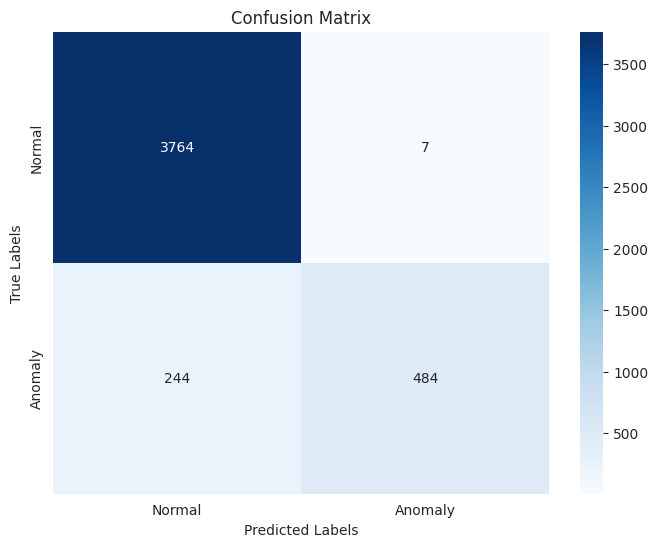

In [142]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


# ATTACKS TYPES WITHOUT LABELS

In [143]:
# Combine anomaly results
df_for_mlp_types = pd.concat([attacks, prepare_dfs([p1_, p2_, p3_, p4_, p5_, p6_])], axis=1).copy()


In [144]:
df_for_mlp_types['Attack'].unique()

array(['benign', 'Spoofing', 'Switch_ON', 'Switch_close', 'Switch_off'],
      dtype=object)

In [145]:
df_for_mlp_types.head()

,Attack,FIT 101,LIT 101,MV 101,P1_STATE,P101 Status,P102 Status,AIT 201,AIT 202,AIT 203,...,LSH 601,LSH 602,LSH 603,LSL 601,LSL 602,LSL 603,P6 STATE,P601 Status,P602 Status,P603 Status
0,benign,0.0,729.8658,1,3,2,1,142.527557,9.293002,198.077423,...,0,0,1,1,1,0,2,1,1,1
1,benign,0.0,729.4340,1,3,2,1,142.527557,9.293002,198.385025,...,0,0,1,1,1,0,2,1,1,1
2,benign,0.0,729.1200,1,3,2,1,142.527557,9.293002,198.436300,...,0,0,1,1,1,0,2,1,1,1
3,benign,0.0,728.6882,1,3,2,1,142.527557,9.289157,198.667000,...,0,0,1,1,1,0,2,1,1,1
4,benign,0.0,727.7069,1,3,2,1,142.527557,9.289157,198.897720,...,0,0,1,1,1,0,2,1,1,1


In [146]:
X_types = df_for_mlp_types.drop(['Attack'], axis=1)
y_types = df_for_mlp_types['Attack']

In [147]:
y_types_encoded = pd.get_dummies(y_types).values

X_train_types, X_test_types, y_train_types, y_test_types = train_test_split(X_types, y_types_encoded, test_size=0.3, random_state=42)

model_types = Sequential([
    Dense(64, activation='relu', input_dim=X_train_types.shape[1]),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(5, activation='softmax')
])

model_types.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_types.fit(X_train_types, y_train_types, epochs=30, batch_size=32, validation_split=0.2)

y_pred_types = model_types.predict(X_test_types)
y_pred_labels_types = np.argmax(y_pred_types, axis=1)
y_test_labels_types = np.argmax(y_test_types, axis=1)

print(classification_report(y_test_labels_types, y_pred_labels_types, target_names=['benign', 'Spoofing', 'Switch_ON', 'Switch_close', 'Switch_off']))

Epoch 1/30


/home/clovinux/venvs/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7117 - loss: 9.1391 - val_accuracy: 0.8238 - val_loss: 0.7877
Epoch 2/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step - accuracy: 0.8426 - loss: 0.6835 - val_accuracy: 0.9381 - val_loss: 0.2627
Epoch 3/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - accuracy: 0.8943 - loss: 0.3480 - val_accuracy: 0.9252 - val_loss: 0.1876
Epoch 4/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step - accuracy: 0.9117 - loss: 0.3162 - val_accuracy: 0.9567 - val_loss: 0.1419
Epoch 5/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - accuracy: 0.9370 - loss: 0.1921 - val_accuracy: 0.9605 - val_loss: 0.1060
Epoch 6/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step - accuracy: 0.9217 - loss: 0.2472 - val_accuracy: 0.8619 - val_loss: 0.4436
Epoch 7/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step - accuracy: 0.9317 - loss: 0.2110 - val_accuracy: 0.9671 - val_loss: 0.0975
Epoch 8/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step - accuracy: 0.9467 - loss: 0.1755 - val_accuracy:

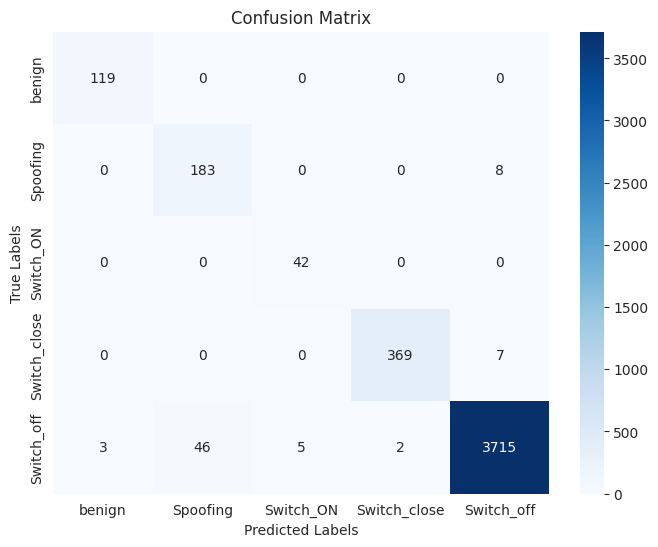

In [148]:
conf_matrix = confusion_matrix(y_test_labels_types, y_pred_labels_types)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['benign', 'Spoofing', 'Switch_ON', 'Switch_close', 'Switch_off'], 
            yticklabels=['benign', 'Spoofing', 'Switch_ON', 'Switch_close', 'Switch_off'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# ***ATTACK TYPES WITH LABELS***

In [149]:
df_for_mlp_types_labels = pd.concat([attacks, labels, prepare_dfs([p1_, p2_, p3_, p4_, p5_, p6_])], axis=1).copy()

In [150]:
X_types_labels = df_for_mlp_types_labels.drop(['Attack'], axis=1)
y_types_labels = df_for_mlp_types_labels['Attack']

In [151]:
y_types_encoded_labels = pd.get_dummies(y_types_labels).values

X_train_types_labels, X_test_types_labels, y_train_types_labels, y_test_types_labels = train_test_split(X_types_labels, y_types_encoded_labels, test_size=0.3, random_state=42)

model_types_labels = Sequential([
    Dense(64, activation='relu', input_dim=X_train_types_labels.shape[1]),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(5, activation='softmax')
])

model_types_labels.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_types_labels.fit(X_train_types_labels, y_train_types_labels, epochs=30, batch_size=32, validation_split=0.2)

y_pred_types_labels = model_types_labels.predict(X_test_types_labels)
y_pred_labels_types_labels = np.argmax(y_pred_types_labels, axis=1)
y_test_labels_types_labels = np.argmax(y_test_types_labels, axis=1)

print(classification_report(y_test_labels_types, y_pred_labels_types, target_names=['benign', 'Spoofing', 'Switch_ON', 'Switch_close', 'Switch_off']))

Epoch 1/30


/home/clovinux/venvs/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7278 - loss: 16.4141 - val_accuracy: 0.8610 - val_loss: 0.5248
Epoch 2/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step - accuracy: 0.8421 - loss: 0.7010 - val_accuracy: 0.8262 - val_loss: 1.2523
Epoch 3/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step - accuracy: 0.8439 - loss: 0.7869 - val_accuracy: 0.9333 - val_loss: 0.1795
Epoch 4/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - accuracy: 0.8927 - loss: 0.3538 - val_accuracy: 0.9143 - val_loss: 0.1945
Epoch 5/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step - accuracy: 0.9109 - loss: 0.3002 - val_accuracy: 0.9319 - val_loss: 0.1471
Epoch 6/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step - accuracy: 0.9225 - loss: 0.2979 - val_accuracy: 0.9386 - val_loss: 0.2480
Epoch 7/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step - accuracy: 0.9286 - loss: 0.2554 - val_accuracy: 0.8881 - val_loss: 0.3930
Epoch 8/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step - accuracy: 0.9309 - loss: 0.2128 - val_accuracy

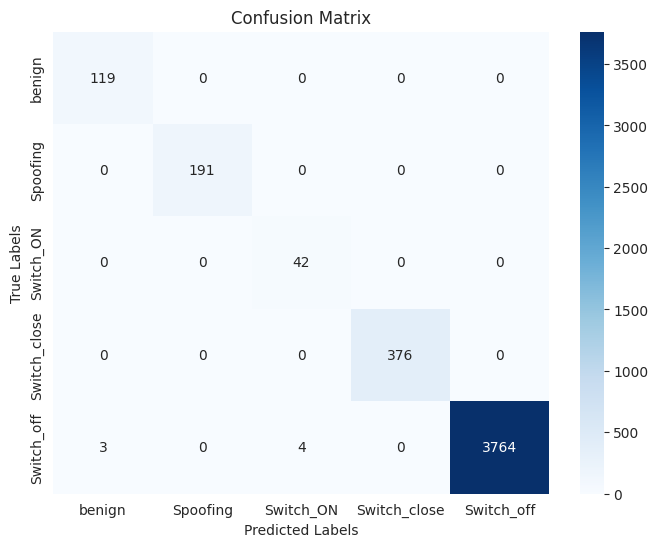

In [152]:
conf_matrix = confusion_matrix(y_test_labels_types_labels, y_pred_labels_types_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['benign', 'Spoofing', 'Switch_ON', 'Switch_close', 'Switch_off'], 
            yticklabels=['benign', 'Spoofing', 'Switch_ON', 'Switch_close', 'Switch_off'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()